In this notebook, we will test several Model proposal

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
A=torch.randn(16,16)
B=torch.randn(16,16)
C=torch.randn(16,16)

In [5]:
a = torch.sigmoid(C.multiply(torch.sigmoid(A.multiply(B))))

In [6]:
b = torch.sigmoid(torch.sigmoid(C.multiply(A)).multiply(B))

In [7]:
torch.dist(A,B)

tensor(23.8962)

# Models

### Simple MPS layer

In [3]:
class MPSLinear(nn.Module):
    '''
    For a naive Linear Layer(in_features,out_features,
                             in_physics_bond = 2, out_physics_bond=2, virtual_bond_dim=2, 
                             bias=True,label_position='center',init_std=1e-10
                                       ): 
        input  (B, in_features)
        output (B, out_features)
    For s simplest MPSLayer(in_features: int, out_features: int, 
                            in_physics_bond: int, out_physics_bond: int, virtual_bond_dim:int,
                            bias: bool = True, label_position: int or str): 
        input  (B, in_features , in_physics_bond)
        output (B, out_features,out_physics_bond)
    '''
    def __init__(self, in_features,out_features,
                                       in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=2, 
                                       bias=True,label_position='center',init_std=1e-10):
        super(MPSLinear, self).__init__()
        if label_position is 'center':
            label_position = in_features//2
        assert type(label_position) is int
        self.in_features   = in_features
        self.out_features  = out_features
        self.vbd           = virtual_bond_dim
        self.ipb           = in_physics_bond
        self.opb           = out_physics_bond
        self.hn            = label_position
        left_num           = self.hn
        right_num          = in_features - left_num

        bias_mat = torch.eye(self.vbd).unsqueeze(-1).repeat(1,1,self.ipb)
        self.left_tensors = nn.Parameter(init_std * torch.randn(left_num         ,self.vbd,self.vbd, self.ipb)+ bias_mat)
        self.rigt_tensors = nn.Parameter(init_std * torch.randn(right_num        ,self.vbd,self.vbd, self.ipb)+ bias_mat)
        
        bias_mat = torch.eye(self.vbd).unsqueeze(-1).repeat(1,1,self.opb)
        self.cent_tensors = nn.Parameter(init_std * torch.randn(self.out_features,self.vbd,self.vbd, self.opb)+ bias_mat)
        
    @staticmethod
    def get_chain_contraction_fast(tensor):
        size   = int(tensor.shape[0])
        while size > 1:
            half_size = size // 2
            nice_size = 2 * half_size
            leftover  = tensor[nice_size:]
            tensor    = torch.einsum("mbik,mbkj->mbij",tensor[0:nice_size:2], tensor[1:nice_size:2])
            #(k/2,NB,D,D),(k/2,NB,D,D) <-> (k/2,NB,D,D)
            tensor   = torch.cat([tensor, leftover], axis=0)
            size     = half_size + int(size % 2 == 1)
        return tensor.squeeze(0)
    
    @staticmethod
    def get_chain_contraction_memory_save(tensor):
        size      = int(tensor.shape[0])
        now_tensor= tensor[0]
        for next_tensor in tensor[1:]:
            now_tensor = torch.einsum("bik,bkj->bij",now_tensor, next_tensor)
        return now_tensor
    
    def get_chain_contraction(self,tensor):
        size   = int(tensor.shape[0])
        D      = int(tensor.shape[-1])
        print(size)
        print(D)
        if D>30:
            return self.get_chain_contraction_memory_save(tensor)
        else:
            return self.get_chain_contraction_fast(tensor)
    
    def forward(self, input_data):
        # the input data shape is (B,L,pd)
        # expand to convolution patch
        embedded_data= input_data
        left_tensors = torch.einsum('wijp,nwp->wnij',self.left_tensors,embedded_data[:,:self.hn])#i.e. (K,NB,b,b)
        rigt_tensors = torch.einsum('wijp,nwp->wnij',self.rigt_tensors,embedded_data[:,-self.hn:])#i.e.(K,NB,b,b)

        left_tensors = self.get_chain_contraction(left_tensors) #i.e. (NB,b,b)
        rigt_tensors = self.get_chain_contraction(rigt_tensors) #i.e. (NB,b,b)

        tensor  = torch.einsum('bip,oplt,bli->bot',left_tensors,self.cent_tensors,rigt_tensors)
        # (NB,b,b) <-> (T,b,b,o) <-> (NB,b,b) ==> (NB,T,t)
        return tensor

In [38]:
import torch
from torch import Tensor
from typing import List, Optional
import numpy as np
from numpy import linalg as LA
import math

def batch_grad_proj(X, D, inner='canonical'):
    r"""project grad data onto Stiefel manifold
    Args:
        X (batch tensor): tensor of parameters in matrix form
        dX (batch tensor): grad tensor of parameters in matrix form
        inner (str, optional): inner product type on Stiefel manifold (default: 'canonical')
    Return:
        G (batch tensor): gradient tensor in matrix form
        A (batch tensor): the tensor G = AX in matrix form
    """
    XT =  X.transpose(-1,-2)
    DT = dX.transpose(-1,-2)
    G  = (dX - 0.5*torch.einsum("...ab,...bc,...cd->...ad",X,XT,D)
             - 0.5*torch.einsum("...ab,...bc,...cd->...ad",X,DT,X))
    
    A = (     torch.einsum("...ab,...bc->...ac", D, XT) 
        -     torch.einsum("...ab,...bc->...ac", X, DT)
        + 0.5*torch.einsum("...ab,...bc,...cd,...de->...ae",X,DT,X,XT)
        - 0.5*torch.einsum("...ab,...bc,...cd,...de->...ae",X,XT,D,XT)
        )
    return G, A
def grad_proj(X, dX, inner='canonical'):
    r"""project grad data onto Stiefel manifold
    Args:
        X (tensor): tensor of parameters in matrix form
        dX (tensor): grad tensor of parameters in matrix form
        inner (str, optional): inner product type on Stiefel manifold (default: 'canonical')
    Return:
        G (tensor): gradient tensor in matrix form
        A (tensor): the tensor G = AX in matrix form
    """
    G = dX - 0.5 * (X @ X.t().conj() @ dX + X @ dX.t().conj() @ X)
    A = dX @ X.t().conj() - X @ dX.t().conj() + 0.5 * X @ (dX.t().conj() @ X - X.t().conj() @ dX) @ X.t().conj()
    return G, A    

def batch_retraction(X, G, A, lr, method='SVD', adapt=False):
    r"""retract the updated tensor onto Stiefel manifold
    Args:
        X (batch tensor): tensor of parameters in matrix form
        G (batch tensor): gradient tensor in matrix form
        A (batch tensor): the tensor G = AX in matrix form
        lr (float): learning rate
        method (str, optional): method for retraction into Stiefel manifold ('SVD', 'Cayley') (default: 'SVD')
    """
    if adapt:
        lr = min(lr, 4.0 / (torch.linalg.norm(A).item() + 1e-8)) 
    if method == 'SVD':
        U, _, Vt = LA.svd((X - lr * G).cpu().numpy(), full_matrices=False)
        X_out = torch.tensor(U @ Vt)
        # U, _, V = svd_(X - lr * G)
        # X_out = U @ V.t()

    elif method == 'Cayley':
        X_out = X - lr * G
        for i in range(40):
            X_out = X - 0.3 * lr * A @ (X + X_out)

    return X_out


In [ ]:
def grad_proj(X, D, inner='canonical'):
    r"""project grad data onto Stiefel manifold
    Args:
        X (batch tensor): tensor of parameters in matrix form
        dX (batch tensor): grad tensor of parameters in matrix form
        inner (str, optional): inner product type on Stiefel manifold (default: 'canonical')
    Return:
        G (batch tensor): gradient tensor in matrix form
        A (batch tensor): the tensor G = AX in matrix form
    """
    XT =  X.transpose(-1,-2)
    DT = dX.transpose(-1,-2)
    G  = (dX - 0.5*torch.einsum("...ab,...bc,...cd->...ad",X,XT,D)
             - 0.5*torch.einsum("...ab,...bc,...cd->...ad",X,DT,X))

    A = (     torch.einsum("...ab,...bc->...ac", D, XT) 
        -     torch.einsum("...ab,...bc->...ac", X, DT)
        + 0.5*torch.einsum("...ab,...bc,...cd,...de->...ae",X,DT,X,XT)
        - 0.5*torch.einsum("...ab,...bc,...cd,...de->...ae",X,XT,D,XT)
        )
    return G, A
    
class Left_Orthogonal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, tensor):
        ctx.save_for_backward(tensor)
        tensor=
        U,_,V = torch.linalg.svd(tensor)
        return torch.einsum("...ab,...bc->...ac",U,V)

    @staticmethod
    def backward(ctx, D):
        X = ctx.saved_tensors
        XT =  X.transpose(-1,-2)
        DT = dX.transpose(-1,-2)
        G  = (dX - 0.5*torch.einsum("...ab,...bc,...cd->...ad",X,XT,D)
                 - 0.5*torch.einsum("...ab,...bc,...cd->...ad",X,DT,X))
        return G

In [61]:
X     = torch.randn(2,3,4)
dX    = torch.randn(2,3,4)
batch_G, batch_A  = batch_grad_proj(X, dX)


In [4]:
import tensornetwork as tn
from tensornetwork import contractors
tn.set_default_backend("pytorch")
class MPSLinear_tn_loop(nn.Module):
    '''
    For s simplest MPSLayer(in_features: int, out_features: int,
                            in_physics_bond: int, 
                            out_physics_bond: int, virtual_bond_dim:int,
                            bias: bool = True, label_position: int or str):
        input  (B, in_features , in_physics_bond)
        output (B, out_features)
    '''
    def __init__(self, in_features,out_features,
                       in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=2,
                       bias=True,label_position='center',init_std=1e-10,**kargs):
        super().__init__()

        if label_position is 'center':
            label_position = in_features//2
        assert type(label_position) is int
        self.in_features   = in_features
        self.out_features  = out_features
        self.vbd           = virtual_bond_dim
        self.ipb           = in_physics_bond
        self.opb           = out_physics_bond
        self.hn            = label_position
        
        left_num           = self.hn
        right_num          = in_features - left_num

        bias_mat     = torch.eye(self.ipb,self.vbd)
        left_end     = init_std * torch.randn(self.ipb,self.vbd) + bias_mat

        bias_mat     = torch.eye(self.vbd, self.ipb)
        right_end    = init_std * torch.randn(self.vbd, self.ipb)+ bias_mat

        bias_mat     = torch.eye(self.vbd).unsqueeze(1).repeat(1,self.ipb,1)
        left_tensors = init_std * torch.randn(left_num-1 ,self.vbd, self.ipb , self.vbd)+ bias_mat
        rigt_tensors = init_std * torch.randn(right_num-1,self.vbd, self.ipb,self.vbd)+ bias_mat


        bias_mat     = torch.eye(self.vbd).unsqueeze(1).repeat(1,self.out_features,1)
        cent_tensors = init_std * torch.randn(self.vbd,self.out_features,self.vbd)+ bias_mat

        mps_var      = [left_end] + list(left_tensors)  + [cent_tensors] + list(rigt_tensors) + [right_end]
        self.mps_var = [nn.Parameter(v) for v in mps_var]
        self.center  = left_num
        for i, v in enumerate(self.mps_var):
            self.register_parameter(f'mps{i}', param=v)

    def contract_mps_with_input(self,input):
        assert len(input) == len(self.mps_var)-1
        mps_list_1   = self.mps_var
        mps_nodes_1  = [tn.Node(v, name=f"t{i}") for i,v in enumerate(mps_list_1)]
        mps_edges_1  = [mps_nodes_1[i][-1]^mps_nodes_1[i+1][0] for i in range(len(mps_nodes_1)-1)]
        inp_nodes    = [tn.Node(v, name=f"i{i}") for i,v in enumerate(input)]
        for i,input_node in enumerate(inp_nodes):
            j = i if i < self.center else i+1
            mps_physicd_edge = mps_nodes_1[j][0] if j==0 else mps_nodes_1[j][1]
            inp_physics_edge = input_node[0]
            tn.connect(mps_physicd_edge,inp_physics_edge,name=f"p_{i}")

        ans = contractors.auto(mps_nodes_1+inp_nodes,
                              output_edge_order=[mps_nodes_1[self.center][1]]).tensor
        return ans

    def forward(self, inputs):
        out = torch.stack([self.contract_mps_with_input(single_input) for single_input in inputs])
        return out
    
class MPSLinear_tn_batch(MPSLinear_tn_loop):
    def forward(self, inputs):
        num        = len(self.mps_var)
        mps_nodes  = [tn.Node(v, name=f"t{i}") for i,v in enumerate(self.mps_var)]
        mps_edges  = [mps_nodes[i][-1]^mps_nodes[i+1][0] for i in range(num-1)]


        inputs= inputs.permute(1,2,0)#(B,num,k)->(num,k,B)
        out   = torch.diag_embed(inputs)#(num,k,B)->(num,k,B,B)
        out   = out.permute(0,2,1,3)#(num,k,B,B)->(num,B,k,B)
        out   = [v for v in out]
        out[0]= torch.diagonal(out[0], dim1=0, dim2=-1).transpose(1,0)#(B,k,B) -> #(B,k)

        inp_nodes=[tn.Node(v, name=f"i{i}") for i,v in enumerate(out)]
        inp_edges=[inp_nodes[0][0]^inp_nodes[1][0]]+ [
            inp_nodes[i][-1]^inp_nodes[i+1][0] for i in range(1,len(inp_nodes)-1)]

        for i,input_node in enumerate(inp_nodes):
            j = i if i < self.center else i+1
            mps_physicd_edge = mps_nodes[j][0] if j==0 else mps_nodes[j][1]
            inp_physics_edge = input_node[1]
            tn.connect(mps_physicd_edge,inp_physics_edge,name=f"p_{i}")

        ans = contractors.auto(mps_nodes+inp_nodes,output_edge_order=[inp_nodes[-1][2],mps_nodes[self.center][1]]).tensor
        return ans

In [91]:
model = MPSLinear_tn_loop(28*28,10,in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=10,
                  bias=False,label_position='center',init_std=1e-2)

In [88]:
model = MPSLinear_tn_batch(28*28,10,in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=10,
                  bias=False,label_position='center',init_std=1e-2)

### AMPS

In [49]:
torch.dist(G,batch_G[0])

tensor(6.7763e-07)

In [79]:
#from models.amps import AMPSShare
class AMPSShare(nn.Module):
    '''
    This version may fast, but will cost much more memory
    n        : the length of input tensor sequence
    bond_dim : the virtual bond dim. The capacity of model.
    phys_dim : the feature/class number
    ------------------------------
    Input:  any data/spin configurations, shape: (B, n ,phys_dim)
    Output: prob_matrix of each sample, shape: (B, n, phys_dim), pass softmax to get probility.
    -------------------------------
    Weight Cost:
        n * bond_dim * bond_dim * phys_dim
    '''
    def __init__(self, n=784, bond_dim=10, phys_dim=2,std=1e-8):
        super(AMPSShare, self).__init__()
        # Initialize AMPS model parameters, which is a (n, D, D, 2) tensor
        self.register_buffer('bias_mat', torch.eye(bond_dim).unsqueeze(-1).repeat(1,1,phys_dim))
        # bias_mat: which is realy important when n>>1
        self.tensors = nn.Parameter(std * torch.randn(n, bond_dim, bond_dim, phys_dim)+self.bias_mat)
        # Set attributes
        self.n = n
        self.bond_dim = bond_dim
        self.std = std

    def forward(self, embedded_data):

        bs = embedded_data.shape[0]
        # local feature map, x_j -> [x_j, 1-x_j]
        #-> embedded_data = torch.stack([data, 1.0 - data], dim=2)  # (bs, n, 2)
        ##logx_hat = torch.zeros_like(embedded_data)
        ##logx_hat[:, 0, :] = F.log_softmax(self.tensors[0, 0, 0], dim=0)
        prob_matrix = self.tensors[0, 0, 0].repeat((bs,1)).unsqueeze(1) # (bs,1,2)
        mats = torch.einsum('lri,bi->blr', self.tensors[0] , embedded_data[:, 0, :])
        left_vec = mats[:, 0:1, :]  # (bs,  D)
        for idx in range(1, self.n):
            # compute p(s_2 | s_1) and so on
            logits = torch.einsum('br, ri->bi', left_vec.squeeze(1),self.tensors[idx,:,0,:])
            #(bs,D) <-> (D,2) ->(bs,2)
            prob_matrix = torch.cat([prob_matrix,logits.unsqueeze(1)], dim=1)
            #(bs, n-2, 2) + (bs,1,2) -> (bs, n-1, 2)
            ##logx_hat[:, idx, :] = F.log_softmax(logits, dim=1)
            mats = torch.einsum('lri,bi->blr', self.tensors[idx, :, :, :] , embedded_data[:, idx, :])
            #(D,D,2) <-> (bs,2) ->(bs,D,D)
            left_vec = torch.bmm(left_vec, mats)  # (bs, 1, D)
        # compute log prob
        return prob_matrix


In [50]:
torch.dist(A,batch_A[0])

tensor(1.1861e-06)

### PEPS

#### naive contractor: face dimenstion explore

In [3]:
import torch

In [7]:
# import torch
# tensor = torch.randn(8,8,6,6,6,6)
# while tensor.shape[0]>2:
#     print(tensor.shape)
#     lu_tensor = tensor[0::2,0::2]
#     ld_tensor = tensor[0::2,1::2]
#     ru_tensor = tensor[1::2,0::2]
#     rd_tensor = tensor[1::2,1::2]
#     tensor     = torch.einsum("xyabcd,xyhdij,xycefg,xyigkl->xyahbefkjl",
#                             lu_tensor,
#                             ld_tensor,
#                             ru_tensor,
#                             rd_tensor).flatten(4,5).flatten(-4,-3).flatten(2,3).flatten(-2,-1)

##### cotengra

In [ ]:
from tensornetwork.contractors.opt_einsum_paths.utils import *
from opt_einsum.paths import greedy

In [ ]:
import opt_einsum as oe
import tensornetwork as tn
tn.set_default_backend("pytorch")

In [1]:
import torch
import opt_einsum as oe
import tensornetwork as tn
tn.set_default_backend("pytorch")
    from tensornetwork.contractors.opt_einsum_paths.utils import *
tensor = torch.randn(16,16,2,2,2,2).cuda()

node_array = []
W,H = tensor.shape[:2]
for i in range(W):
    node_line = []
    for j in range(H):
        node = tn.Node(tensor[i][j],name=f"{i}-{j}")
        node_line.append(node)
    node_array.append(node_line)

for i in range(W):
    for j in range(H):
        if j==H-1:tn.connect(node_array[i][j][2],node_array[i  ][0  ][0],f"{i}{j}<->{i}{0}")
        else:     tn.connect(node_array[i][j][2],node_array[i  ][j+1][0],f"{i}{j}<->{i}{j+1}")
        if i==W-1:tn.connect(node_array[i][j][3],node_array[0  ][j  ][1],f"{i}{j}<->{0}{j}")
        else:     tn.connect(node_array[i][j][3],node_array[i+1][j  ][1],f"{i}{j}<->{i+1}{j}")

node_list = [item for sublist in node_array for item in sublist]
nodes = node_list
input_sets = [set(node.edges) for node in nodes]
output_set = get_subgraph_dangling(nodes)
size_dict = {edge: edge.dimension for edge in get_all_edges(nodes)}

operands = []
for node,edge_label in zip(node_list,input_sets):
    operands+=[node.tensor,[edge.name for edge in edge_label]]

path,info = oe.contract_path(*operands)

small_cores =[node.tensor for node in node_list]
import tqdm as tqdm
import cotengra as ctg

sf = ctg.SliceFinder(info, target_size=2**27)
inds_to_slice, cost_of_slicing = sf.search()

In [17]:
import tqdm as tqdm
import cotengra as ctg

sf = ctg.SliceFinder(info, target_size=2**27)
inds_to_slice, cost_of_slicing = sf.search()

In [18]:
print(cost_of_slicing.size    ) # the new largest intermediate
print(cost_of_slicing.overhead)  # theoretical 'slowdown'

67108864
2.9753197715379116


In [19]:
sc = sf.SlicedContractor([*small_cores])
result = sum(sc.contract_slice(i) for i in tqdm.trange(sc.nslices))
# 100%|██████████| 512/512 [00:55<00:00,  9.30it/s]



  0%|          | 0/262144 [00:00<?, ?it/s]

  0%|          | 15/262144 [00:00<30:05, 145.21it/s]

  0%|          | 30/262144 [00:00<44:00, 99.28it/s] 

  0%|          | 41/262144 [00:00<47:41, 91.58it/s]

  0%|          | 51/262144 [00:00<49:42, 87.88it/s]

  0%|          | 60/262144 [00:00<50:56, 85.76it/s]

  0%|          | 69/262144 [00:00<51:48, 84.32it/s]

  0%|          | 78/262144 [00:00<52:24, 83.35it/s]

  0%|          | 87/262144 [00:00<53:13, 82.06it/s]

  0%|          | 96/262144 [00:01<53:42, 81.31it/s]

  0%|          | 105/262144 [00:01<53:43, 81.29it/s]

  0%|          | 114/262144 [00:01<53:46, 81.21it/s]

  0%|          | 123/262144 [00:01<53:46, 81.20it/s]

  0%|          | 132/262144 [00:01<53:47, 81.19it/s]

  0%|          | 141/262144 [00:01<53:47, 81.18it/s]

  0%|          | 150/262144 [00:01<53:49, 81.13it/s]

  0%|          | 159/262144 [00:01<53:48, 81.14it/s]

  0%|          | 168/262144 [00:01<53:57, 80.91it/s]

  0%|          | 177/262144 [00:02<54:10, 8

KeyboardInterrupt: 

In [7]:
import torch
import opt_einsum as oe

In [ ]:
tensor = torch.randn(12,12,4,4,4,4)/2
#tensor     = torch.randn(2,2,16,16,16,16)/10
computer_vie_tn(tensor)

[(0, 8), (0, 7), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (1, 2), (0, 1), (0, 9), (0, 8), (0, 8), (0, 7), (0, 6), (1, 5), (1, 4), (1, 3), (1, 4), (3, 13), (7, 12), (3, 11), (3, 10), (3, 9), (3, 8), (6, 7), (3, 6), (3, 5), (3, 4), (2, 6), (2, 10), (1, 11), (4, 11), (0, 13), (5, 12), (5, 12), (6, 12), (5, 12), (6, 11), (6, 11), (6, 12), (4, 12), (6, 13), (7, 14), (7, 13), (4, 12), (6, 11), (6, 11), (6, 10), (6, 10), (0, 11), (0, 11), (5, 10), (0, 9), (4, 9), (2, 9), (1, 8), (3, 7), (3, 7), (3, 9), (3, 9), (3, 10), (3, 10), (3, 9), (3, 8), (1, 7), (2, 6), (6, 7), (2, 6), (2, 5), (2, 5), (5, 17), (6, 18), (12, 21), (4, 23), (13, 22), (4, 21), (15, 23), (10, 23), (10, 22), (7, 27), (11, 27), (11, 27), (11, 26), (7, 29), (9, 29), (8, 28), (15, 29), (7, 28), (13, 29), (6, 31), (6, 30), (13, 29), (16, 29), (1, 20), (21, 26), (21, 25), (6, 24), (15, 30), (15, 29), (8, 28), (10, 27), (6, 27), (10, 26), (8, 25), (9, 24), (5, 23), (2, 21), (10, 25), (5, 24), (2, 23), (1, 33), (1, 21), (0, 31), (2, 

### Kite

In [1]:
import torch

In [36]:
D = 5
W=H=16

In [142]:
import opt_einsum as oe

for even size

In [49]:
physics_tensor = torch.randn(W,H,D,D,D,D)
size = W
hat_tensor_list=[]
while size>1:
    hat_tensor = torch.randn(2,2,size//2,size//2,D,D,D)
    size       = size//2
    hat_tensor_list.append(hat_tensor)

In [42]:
left_top = physics_tensor[0::2,0::2]
rigt_top = physics_tensor[0::2,1::2]
rigt_bot = physics_tensor[1::2,1::2]
left_bot = physics_tensor[1::2,0::2]

In [51]:
for hat_tensor in hat_tensor_list:
    left_top = physics_tensor[0::2,0::2]
    rigt_top = physics_tensor[0::2,1::2]
    rigt_bot = physics_tensor[1::2,1::2]
    left_bot = physics_tensor[1::2,0::2]
    left_hat = hat_tensor[0,0]
    topp_hat = hat_tensor[0,1]
    rigt_hat = hat_tensor[1,1]
    bott_hat = hat_tensor[1,0]
    physics_tensor = oe.contract("...abcd,...cefg,...hgij,...kdhl,...mak,...bne,...foi,...ljp->...mnop",
                        left_top,rigt_top,rigt_bot,left_bot,
                        left_hat,topp_hat,rigt_hat,bott_hat,optimize=path)
    if len(physics_tensor)==1:break
torch.einsum("...aabb->...")

In [52]:
physics_tensor

torch.Size([1, 1, 5, 5, 5, 5])

In [19]:
path,info = oe.contract_path("...abcd,...cefg,...hgij,...kdhl,...mak,...bne,...foi,...ljp->...mnop",
                             left_top,rigt_top,rigt_bot,left_bot,
                             left_hat,topp_hat,rigt_hat,bott_hat)

for odd size

In [2]:
list(range(1,10,2))

[1, 3, 5, 7, 9]

In [20]:
import numpy as np

In [23]:
(list(range(0,W//2,2))+list(range(W-W//2,W,2))

SyntaxError: unexpected EOF while parsing (<ipython-input-23-82419a86360d>, line 1)

In [47]:
W=H=6

In [156]:
def get_corner_idx(W,H):
    assert W==H
    if W%2 == 0:
        left_top_idx = [t.transpose().flatten() for t in np.meshgrid(range(0,W,2),range(0,H,2))]
        rigt_top_idx = [t.transpose().flatten() for t in np.meshgrid(range(0,W,2),range(1,H,2))]
        rigt_bot_idx = [t.transpose().flatten() for t in np.meshgrid(range(1,W,2),range(1,H,2))]
        left_bot_idx = [t.transpose().flatten() for t in np.meshgrid(range(1,W,2),range(0,H,2))]
        verical_idx  = [None,None]
        horizon_idx  = [None,None]
        center_idx   = [None,None]
    else:
        w_half  = W-W//2+(W%4)//2
        h_half  = H-H//2+(H%4)//2
        left_top_idx = [t.transpose() for t in np.meshgrid(list(range(0,W//2,2))+list(range(w_half,W,2)) ,
                                                                     list(range(0,H//2,2))+list(range(h_half,W,2)))]
        rigt_top_idx = left_top_idx[0]    ,left_top_idx[1]+1
        rigt_bot_idx = left_top_idx[0] + 1,left_top_idx[1]+1
        left_bot_idx = left_top_idx[0] + 1,left_top_idx[1]
        
        widx = np.array(list(range(0,W//2,2))+list(range(w_half,W,2)))
        cent_top_idx = widx, np.array([h_half-1]*len(widx))
        cent_bot_idx = cent_top_idx[0]+1, cent_top_idx[1]
        hidx = np.array(list(range(0,H//2,2))+list(range(h_half,H,2)))
        cent_lft_idx = np.array([w_half-1]*len(hidx)),hidx
        cent_rgt_idx = cent_lft_idx[0],cent_lft_idx[1]+1
        center_idx   = w_half,h_half
    return ((left_top_idx[0].tolist(),left_top_idx[1].tolist()),
            (rigt_top_idx[0].tolist(),rigt_top_idx[1].tolist()),
            (rigt_bot_idx[0].tolist(),rigt_bot_idx[1].tolist()),
            (left_bot_idx[0].tolist(),left_bot_idx[1].tolist()),
            (cent_top_idx[0].tolist(),cent_top_idx[1].tolist()),
            (cent_bot_idx[0].tolist(),cent_bot_idx[1].tolist()),
            (cent_lft_idx[0].tolist(),cent_lft_idx[1].tolist()),
            (cent_rgt_idx[0].tolist(),cent_rgt_idx[1].tolist()),
             center_idx,
           )
             

In [ ]:
        cent_top_idx = rigt_top_idx[0], np.array(list(range(0,H//2,2))+list(range(h_half,H,2)))
        cent_bot_idx = cent_top_idx[0], cent_top_idx[1]+1
        cent_lft_idx = np.array(list(range(0,W//2,2))+list(range(w_half,W,2))),left_top_idx[1]
        cent_rgt_idx = cent_lft_idx[0]+1,cent_lft_idx[1]

In [128]:
cent_top_idx

([0, 2, 5], [5, 5, 5, 5, 5, 5])

In [143]:
import opt_einsum as oe

In [171]:
W=H=7
D=5
(left_top_idx,rigt_top_idx,rigt_bot_idx,left_bot_idx,
 cent_top_idx,cent_bot_idx,cent_lft_idx,cent_rgt_idx,center_idx)= get_corner_idx(W,H)
#physics_tensor = torch.arange(W*H).reshape(W,H)
physics_tensor = torch.randn(W,H,D,D,D,D)
left_top = physics_tensor[left_top_idx[0],left_top_idx[1]]
rigt_top = physics_tensor[rigt_top_idx[0],rigt_top_idx[1]]
rigt_bot = physics_tensor[rigt_bot_idx[0],rigt_bot_idx[1]]
left_bot = physics_tensor[left_bot_idx[0],left_bot_idx[1]]

hat_lrlr_tensor= torch.randn(2,2,(W//2),(H//2),D,D,D)
left_hat = hat_lrlr_tensor[0,0]
topp_hat = hat_lrlr_tensor[0,1]
rigt_hat = hat_lrlr_tensor[1,1]
bott_hat = hat_lrlr_tensor[1,0]
left_top__rigt_top__left_bot__rigt_bot = oe.contract("...abcd,...cefg,...hgij,...kdhl,...mak,...bne,...foi,...ljp->...mnop",
                        left_top,rigt_top,rigt_bot,left_bot,
                        left_hat,topp_hat,rigt_hat,bott_hat#,optimize=path
                                                    )
cent_top = physics_tensor[cent_top_idx[0],cent_top_idx[1]]
cent_bot = physics_tensor[cent_bot_idx[0],cent_bot_idx[1]]
cent_lft = physics_tensor[cent_lft_idx[0],cent_lft_idx[1]]
cent_rgt = physics_tensor[cent_rgt_idx[0],cent_rgt_idx[1]]

cent_lft_hat,cent_rgt_hat = torch.randn(2,(H//2),D,D,D)
cent_vertical_left_top_right_bot = oe.contract("...abcd,...edfg,...hae,...cif->...hbig",
                        cent_top,cent_bot,cent_lft_hat,cent_rgt_hat,
                        )

cent_top_hat,cent_bot_hat = torch.randn(2,(H//2),D,D,D)
cent_horenzon_left_top_right_bot = oe.contract("...abcd,...cefg,...bhe,...dgi->...ahfi",
                        cent_lft,cent_rgt,cent_top_hat,cent_bot_hat,
                        )
center   = physics_tensor[center_idx[0],center_idx[1]]

W,H= left_top__rigt_top__left_bot__rigt_bot.shape[:2]
w_h= W//2 + W%2 
h_h= H//2 + H%2 
left_top = left_top__rigt_top__left_bot__rigt_bot[:w_h,:h_h]
rigt_top = left_top__rigt_top__left_bot__rigt_bot[w_h:,:h_h]
rigt_bot = left_top__rigt_top__left_bot__rigt_bot[w_h:,h_h:]
left_bot = left_top__rigt_top__left_bot__rigt_bot[:w_h,h_h:]
cent_top = cent_vertical_left_top_right_bot[:h_h].unsqueeze(0)
cent_bot = cent_vertical_left_top_right_bot[h_h:].unsqueeze(0)
cent_lft = cent_horenzon_left_top_right_bot[:w_h].unsqueeze(1)
cent_rgt = cent_horenzon_left_top_right_bot[w_h:].unsqueeze(1)
cent_cet = center.unsqueeze(0).unsqueeze(0)
new_tensor = torch.cat([torch.cat([left_top,cent_top,rigt_top],dim=0),
                        torch.cat([cent_lft,cent_cet,cent_rgt],dim=0),
                        torch.cat([left_bot,cent_bot,rigt_bot],dim=0)],dim=1)


In [196]:
new_tensor.shape 

torch.Size([4, 4, 5, 5, 5, 5])

In [164]:
D=5;W=H=7
physics_tensor = torch.arange(W*H).reshape(W,H)
(left_top_idx,rigt_top_idx,rigt_bot_idx,left_bot_idx,
 cent_top_idx,cent_bot_idx,cent_lft_idx,cent_rgt_idx,center_idx)= get_corner_idx(W,H)
left_top = physics_tensor[left_top_idx[0],left_top_idx[1]]
rigt_top = physics_tensor[rigt_top_idx[0],rigt_top_idx[1]]
rigt_bot = physics_tensor[rigt_bot_idx[0],rigt_bot_idx[1]]
left_bot = physics_tensor[left_bot_idx[0],left_bot_idx[1]]
cent_top = physics_tensor[cent_top_idx[0],cent_top_idx[1]]
cent_bot = physics_tensor[cent_bot_idx[0],cent_bot_idx[1]]
cent_lft = physics_tensor[cent_lft_idx[0],cent_lft_idx[1]]
cent_rgt = physics_tensor[cent_rgt_idx[0],cent_rgt_idx[1]]

In [158]:
physics_tensor

tensor([[ 0,  1,  2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11, 12, 13],
        [14, 15, 16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25, 26, 27],
        [28, 29, 30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39, 40, 41],
        [42, 43, 44, 45, 46, 47, 48]])

In [165]:
cent_top

tensor([ 4, 18, 39])

### arbitary partition

In [32]:
from models.tensornetwork_base import TN_Base
import torch.nn as nn
import numpy as np
import copy
import opt_einsum as oe

In [33]:
# import torch
# from models.convND import convNd

# import traceback

# class scaled_Tanh(nn.Module):
#     def __init__(self,coef):
#         super().__init__()
#         self.nonlinear=  nn.Tanh()
#         self.coef = coef
#     def forward(self,x):
#         x = self.nonlinear(x)
#         x = x/self.coef
#         return x

# def get_ConND(in_channels,out_channels,num_dims,bias=True,**kargs):
#     if num_dims == 1:
#         cnn = torch.nn.Conv1d(in_channels,out_channels,bias=bias,**kargs)
#     elif num_dims == 2:
#         cnn = torch.nn.Conv2d(in_channels,out_channels,bias=bias,**kargs)
#     elif num_dims == 3:
#         cnn = torch.nn.Conv3d(in_channels,out_channels,bias=bias,**kargs)
#     else:
#         cnn = convNd(in_channels=in_channels,out_channels=out_channels,num_dims=num_dims,use_bias=bias,
#                       **kargs)
#     return cnn

# class TensorNetConvND(nn.Module):
    
#     def reset_parameters(self):
#         def init_weights(m):
#             if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
#                 torch.nn.init.xavier_uniform_(m.weight)
#                 #torch.nn.init.kaiming_normal_(m.weight) for leack ReLU
#                 if m.bias is not None:torch.nn.init.zeros_(m.bias)
#         self.apply(init_weights)
    
#     def forward(self,x):
#         squeeze = False
#         if len(x.shape) ==self.num_dims + 1:      
#             x = x.unsqueeze(1)
#             squeeze=True
#         res = x
#         out = self.engine(x)
#         out+= res
#         x = self.resize_layer(out)
#         if squeeze:
#             x = x.squeeze(1)
#         return x

# class TensorNetConvND_Single(TensorNetConvND):
#     def __init__(self,shape,offset,channels):
#         super().__init__()
#         num_dims      = len(shape) - offset
#         self.num_dims = num_dims
#         in_channels = out_channels = channels
#         kargs = {'kernel_size':3,
#                  'stride':1,
#                  'padding':1,
#                 }
#         active_shape = shape[offset:]
#         cnn1 = get_ConND(in_channels,out_channels,num_dims,bias=False,**kargs)
#         bn1  = nn.LayerNorm(active_shape)
#         self.engine = nn.Sequential(cnn1,bn1)
        
        
#         factor = np.prod(active_shape)
#         mi  = 1.0/len(active_shape)
#         #coef   = np.sqrt(np.sqrt(factor))
#         coef   = np.sqrt(np.power(factor,mi))
#         self.resize_layer=scaled_Tanh(coef)
#         self.reset_parameters()

# class TensorNetConvND_Block_a(TensorNetConvND):
#     def __init__(self,shape,offset,channels,interchannels=4):
#         super().__init__()
#         num_dims      = len(shape) - offset
#         self.num_dims = num_dims
#         in_channels = out_channels = channels
#         kargs = {'kernel_size':3,
#                  'stride':1,
#                  'padding':1,
#                 }
#         active_shape = shape[offset:]
#         cnn1 = get_ConND(  in_channels,interchannels,num_dims,bias=False,**kargs)
#         cnn2 = get_ConND(interchannels,out_channels ,num_dims,bias=False,**kargs)
#         relu = nn.Tanh()
#         bn1  = nn.LayerNorm(active_shape)
#         bn2  = nn.LayerNorm(active_shape)
#         self.engine = nn.Sequential(cnn1,bn1,relu,cnn2,bn2)
        
        
#         factor = np.prod(active_shape)
#         mi  = 1.0/len(active_shape)
#         #coef   = np.sqrt(np.sqrt(factor))
#         coef   = np.sqrt(np.power(factor,mi))
#         self.resize_layer=scaled_Tanh(coef)
#         self.reset_parameters()

In [18]:
from models.two_dim_model import *
from models.extend_model import *
class PEPS_einsum_arbitrary_partition_optim(TN_Base):
    def __init__(self,out_features=None,
                      virtual_bond_dim=None,#"models/arbitary_shape/arbitary_shape_16x9_2.json",
                      label_position=None,#=(8,4),
                       fixed_virtual_dim=None,
                       patch_engine=torch.nn.Identity,
                       symmetry=None,#"Z2_16x9",
                       seted_variation=10,
                       init_std=1e-10,
                       solved_std=None,
                       convertPeq1=False,re_cal_path=False,complex_number_mode=False):
        super().__init__()
        assert out_features is not None
        assert virtual_bond_dim is not None
        assert label_position is not None
        self.convertPeq1  = convertPeq1
        self.out_features = out_features
        if isinstance(virtual_bond_dim,str):
            arbitary_shape_state_dict = torch.load(virtual_bond_dim)
        else:
            arbitary_shape_state_dict = virtual_bond_dim
        assert isinstance(arbitary_shape_state_dict,dict)


        info_per_group = arbitary_shape_state_dict['node']
        info_per_line  = arbitary_shape_state_dict['line']
        info_per_point = arbitary_shape_state_dict['element']



        #symmetry_map = FFT_Z2_symmetry_16x9_point
        symmetry_map,symmetry_map_point = self.generate_symmetry_map(symmetry,info_per_point)

        # if we use the symmetry, we need to make sure not only the tensor shape but also the
        # object that each tensor leg point. That is we need to realign the neighbor for each point.
        for group_now in range(len(info_per_group)):
            neighbors = info_per_group[group_now]['neighbor']# neighbors is also a group
            unique_id = [min(symmetry_map[neighbor_id]) for neighbor_id in neighbors]
            new_order = np.argsort(unique_id)
            #print(f"group-{group_now}: old neighbors{neighbors} real neighbor {unique_id} new order {new_order}")
            info_per_group[group_now]['neighbor'] = [neighbors[i] for i in new_order]
            elements  =  info_per_group[group_now]['element']
            unique_id = [min(symmetry_map_point[element]) for element in elements]
            new_order = np.argsort(unique_id)
            info_per_group[group_now]['element'] = [elements[i] for i in new_order]

        # if the element in group is symmetric, for example, if (15,0) and (1,0) in the same group, then the regist weight A(#Element,D,D,D,D)
        # should hold same symmetry along #Element dimension. That is, if we set (15,0) to the A[0](D,D,D,D) and (1,0) to the A[1](D,D,D,D),
        # then should have A[0]==A[1]
        for group_now,pool in info_per_group.items():
            in_symmetry_idx     = {}
            for idx, point in enumerate(pool['element']):
                in_symmetry_idx[idx]= [idx]
                for string_id in symmetry_map_point[point]:# the symmetry_map_point return string point position, for example '15-0'
                    real_point_pos = tuple([int(s) for s in string_id.split('-')])
                    if real_point_pos != point and real_point_pos in pool['element']: # exclude the itself, and its symmetry part in element list
                        the_idx_for_symmetry_point_in_element=pool['element'].index(real_point_pos)
                        in_symmetry_idx[idx].append(the_idx_for_symmetry_point_in_element)

            the_symmetry_permutation=[]
            has_symmetry_point = False
            for idx, point in enumerate(pool['element']):
                if len(in_symmetry_idx[idx])>1:has_symmetry_point=True
                if len(in_symmetry_idx[idx])>2:
                    raise NotImplezntedError("we now don't support the case that have more than 2 symmetric point in one group")
                the_symmetry_permutation.append(in_symmetry_idx[idx][-1])
            if has_symmetry_point:
                pool['in_group_symmetry_permutation'] = the_symmetry_permutation
            else:
                pool['in_group_symmetry_permutation'] = None

        if fixed_virtual_dim is not None:
            for key in info_per_line.keys():
                info_per_line[key]['D'] = fixed_virtual_dim
        #since we use symmetry than the center group could not in the symmetry part
        center_group = None
        if label_position != 'no_center':

            center_group = info_per_point[label_position]['group']
            damgling_num = len(info_per_group)
            info_per_group[center_group]['neighbor'].insert(0,damgling_num)
            info_per_line[(center_group,damgling_num)]={'D': out_features}
            symmetry_map[damgling_num]=set([damgling_num])
        else:
            assert out_features == 1
        operands = []
        sublist_list=[]

        ranks_list=[]

        #absolute_line_id = {}
        for group_now in range(len(info_per_group)):
            group_info= info_per_group[group_now]
            neighbors = group_info['neighbor']
            ranks = []
            sublist=[]

            for neighbor_id in neighbors:
                line_tuple = [group_now,neighbor_id]
                line_tuple.sort()
                line_tuple= tuple(line_tuple)
                D = int(info_per_line[line_tuple]['D'])
                #if line_tuple not in absolute_line_id:absolute_line_id[line_tuple] = len(absolute_line_id)
                #idx = absolute_line_id[line_tuple]
                idx = list(info_per_line.keys()).index(line_tuple)

                ranks.append(D)
                sublist.append(idx)
            tensor = np.random.randn(*ranks)
            operands+=[tensor,[*sublist]]

            ranks_list.append(ranks)
            sublist_list.append(sublist)
        if center_group is not None:
            outlist  = [list(info_per_line.keys()).index((center_group,damgling_num))]
        else:
            outlist  = []
        # line_tuple = (center_group,damgling_num)
        # #if line_tuple not in absolute_line_id:absolute_line_id[line_tuple] = len(absolute_line_id)
        # idx = absolute_line_id[line_tuple]
        # outlist = [idx]
        operands+= [[*outlist]]


        self.operands_string = full_size_array_string(*operands)
        #path,info = oe.contract_path(*operands,optimize='random-greedy-128')
        path = get_best_path_via_oe(*operands,store="models/arbitrary_shape_path_recorder.json",re_saveQ=re_cal_path)
        self.path         = path
        self.sublist_list = sublist_list
        self.outlist      = outlist


        unique_unit_list = []
        # the unique unit list is the real weight for training of the model
        # if there is no symmetry assign, then each group/block would allocate a weight
        # then the len(unique_unit_list) == len(info_per_group)
        # if there is symmetry, then some groups share the weight
        # then the len(unique_unit_list) < len(info_per_group)
        for i in range(len(sublist_list)):

            for the_symmetry_counterpart in symmetry_map[i]:
                if 'weight_idx' in info_per_group[the_symmetry_counterpart]:
                    info_per_group[i]['weight_idx']=info_per_group[the_symmetry_counterpart]["weight_idx"]
                    info_per_group[i]['symmetry_indices']=info_per_group[the_symmetry_counterpart]["symmetry_indices"]
                    break
            if 'weight_idx' in info_per_group[i]:
                continue
            # assume all element for the tensornetwork is indenpendent.
            # The bond (include physics) list is l0,l1,l2,...,ln
            # All element follow normal distribution X - sigma(0,alpha)
            # where alpha is the variation we need to calculated.
            # the output after contracting is also a tensor (may 1-rank scalar, 2-rank matrix, etc)
            # the element of the output follow the composite normal distribution Y - sigma(0,beta)
            # where beta = l0 x l1 x l2 x ... x ln x alpha^(# of tensor)

            # if we active the Z2 symmetry, not only the left and right part should be reflected, but also
            # the center part. Since the center part link two same region, then it should be the symmetry
            # matrix for the bond it connected.
            # we would firstly check the neighbor of the group
            unique_neighbor_group = [min(symmetry_map[neighbor_id]) for neighbor_id in info_per_group[i]['neighbor']]
            symmetry_indices=None
            for j in set(unique_neighbor_group):
                if unique_neighbor_group.count(j)>1:
                    symmetry_leg_pos = list(np.where(np.array(unique_neighbor_group)==j)[0]+1)# plus 1 since we would add physics dim
                    if symmetry_indices is not None:
                        raise NotImplementedError("we now only support one symmetry indices")
                    symmetry_indices = list(permutations((symmetry_leg_pos)))
            info_per_group[i]['symmetry_indices'] = symmetry_indices
            info_per_group[i]['weight_idx']       = len(unique_unit_list)


            shape = ranks_list[i]
            P     = len(info_per_group[i]['element'])
            if self.convertPeq1:
                if self.convertPeq1 == 'all_convert':
                    P = 2*P
                else:
                    P     = 2 if P==1 else P

            #control_mat = self.rde2D((P,*shape),0,physics_index=0,offset= 2 if i==center_group else 1)
            #bias_mat    = torch.normal(0,solved_std,(P,*shape))
            #bias_mat[control_mat.nonzero(as_tuple=True)]=0
            #unique_unit_list.append(control_mat+bias_mat)
            if complex_number_mode:shape.append(2)
            unique_unit_list.append(self.rde2D((P,*shape),init_std,offset=1))
            #unique_unit_list.append(torch.normal(mean=0,std=solved_std,size=(P,*shape)))
        #assert len(unit_list)==len(sublist_list)
        
        if complex_number_mode:
            self.unique_unit_list         = [nn.Parameter(torch.view_as_complex(v)) for v in unique_unit_list]
        else: 
            self.unique_unit_list         = [nn.Parameter(v) for v in unique_unit_list]
        self.unique_groupwise_backend = nn.ModuleList()
        if center_group is not None:
            center_group_unique_idx = info_per_group[center_group]["weight_idx"]
        else:
            center_group_unique_idx = "-1"
        for i,v in enumerate(unique_unit_list):
            if i == center_group_unique_idx:
                offset = 2
                inchan = out_features
            else:
                offset = 1
                inchan = 1
            if complex_number_mode:
                self.unique_groupwise_backend.append(patch_engine(v.shape[offset:-1],inchan))
            else:
                self.unique_groupwise_backend.append(patch_engine(v.shape[offset:],inchan))
        for i, v in enumerate(self.unique_unit_list):self.register_parameter(f'unit_{i}', param=v)
        #put the tensor into the AD graph.
        #assert len(self.unit_list)==len(sublist_list)
        self.info_per_group=info_per_group
        self.info_per_line =info_per_line
        self.info_per_point=info_per_point
        self.symmetry_map  =symmetry_map
        self.symmetry_map_point =symmetry_map_point
        self.pre_activate_layer = nn.Identity()
        self.debugQ=False
        self.complex_number_mode = complex_number_mode
    def generate_symmetry_map(self,symmetry,info_per_point):
        symmetry_map       = {}
        symmetry_map_point = {}
        for i,j in info_per_point.keys():
            group_now  = info_per_point[i,j]['group']
            symmetry_map[group_now]= set([group_now])
            symmetry_map_point[i,j]= set([f"{i}-{j}"])
        if symmetry is not None:
            if symmetry == "Z2_16x9":
                for i in list(range(1,8))+list(range(9,16)):
                    for j in range(9):
                        group_now  = info_per_point[i,j]['group']
                        for x, y in [[16-i,j]]:
                            group_sym  = info_per_point[x,y]['group']
                            symmetry_map[group_now]=symmetry_map[group_now]|set([group_sym])
                            symmetry_map_point[i,j]=symmetry_map_point[i,j]|set([f"{x}-{y}"])
            elif symmetry == "Z2_16x16":
                for i in range(16):
                    for j in range(16):
                        group_now  = info_per_point[i,j]['group']

                        for x, y in [[i,15-j],[15-i,j],[15-i,15-j]]:
                            group_sym  = info_per_point[x,y]['group']
                            symmetry_map[group_now]=symmetry_map[group_now]|set([group_sym])
                            symmetry_map_point[i,j]=symmetry_map_point[i,j]|set([f"{x}-{y}"])

            else:
                raise NotImplementedError
        return symmetry_map,symmetry_map_point

    def weight_init(self,method=None,set_var=1):
        if method is None:return
        if method == "Expecatation_Normalization":
            num_of_tensor   = len(self.info_per_group)
            list_of_virt_dim= [t['D'] for t in self.info_per_line.values()]
            # notice, we cannot count the class label
            list_of_virt_dim.append(1/self.out_features)
            list_of_phys_dim= [len(t['element']) for t in self.info_per_group.values()]
            divider         = np.prod([np.power(t,1/num_of_tensor) for t in list_of_phys_dim+list_of_virt_dim])
            solved_var      = np.power(set_var,1/num_of_tensor)/divider
            solved_std      = np.sqrt(solved_var)
            for i in range(len(self.unique_unit_list)):
                self.unique_unit_list[i] = torch.nn.init.normal_(self.unique_unit_list[i],mean=0.0, std=solved_std)
        elif method == "Expecatation_Normalization2":
            num_of_tensor   = len(self.info_per_group)
            list_of_virt_dim= [t['D'] for t in self.info_per_line.values()]
            # notice, we cannot count the class label
            list_of_virt_dim.append(1/self.out_features)
            list_of_phys_dim= [len(t['element']) for t in self.info_per_group.values()]
            divider         = np.prod([np.power(t,1/num_of_tensor) for t in list_of_virt_dim])
            solved_var      = np.power(set_var,1/num_of_tensor)/divider
            solved_std      = np.sqrt(solved_var)
            for i in range(len(self.unique_unit_list)):
                self.unique_unit_list[i] = torch.nn.init.normal_(self.unique_unit_list[i],mean=0.0, std=solved_std)
        elif method == "fixpoint_start":
            for i in range(len(self.unique_unit_list)):
                shape = self.unique_unit_list[i].shape
                offset= 1
                size_shape = shape[:offset]
                bias_shape = shape[offset:]
                max_dim    = max(bias_shape)
                full_rank  = len(bias_shape)
                half_rank  = full_rank//2
                rest_rank  = full_rank-half_rank
                bias_mat   = torch.eye(max_dim**half_rank,max_dim**rest_rank)
                bias_mat   = bias_mat.reshape(*([max_dim]*full_rank))
                for j,d in enumerate(bias_shape):
                    bias_mat   = torch.index_select(bias_mat, j,torch.arange(d))
                norm   = np.sqrt(np.prod(bias_shape))
                norm  *= np.sqrt(size_shape[0])
                #print(norm)

                bias_mat  /= norm
                bias_mat   = bias_mat.repeat(*size_shape,*([1]*len(bias_shape)))

                with torch.no_grad():
                    self.unique_unit_list[i] = torch.nn.init.normal_(self.unique_unit_list[i],mean=0.0, std=np.sqrt(set_var))
                    self.unique_unit_list[i].add_(bias_mat)
        elif method == "normlization_to_one":
            for i in range(len(self.unique_unit_list)):
                with torch.no_grad():
                    self.unique_unit_list[i].div_(torch.norm(self.unique_unit_list[i]))
        else:
            raise NotImplementedError(f"we dont have init option:{method}")

    def get_batch_input(self,input_data):
        #input data shape B,1,W,H
        assert len(input_data.shape)==4
        assert np.prod(input_data.shape[-2:])==len(self.info_per_point)
        input_data  = input_data.squeeze(1)

        _input = []
        _units = []
        #for i,((unit,symmetry_indices),point_idx) in enumerate(zip(unit_list,self.point_of_group)):
        for i in range(len(self.info_per_group)):
            #patch_idx  = self.info_per_group[i]['element_idx']
            #print(f"processing unit {i}: conclude point{patch_idx}")
            #batch_input= input_data[...,patch_idx] # B,P
            pool = self.info_per_group[i]
            point_idx = np.array(pool['element']).transpose()
            #print(info_per_group[i]["weight_idx"])
            unit             = self.unique_unit_list[pool["weight_idx"]]
            if pool['in_group_symmetry_permutation'] is not None:
                unit = (unit + unit[pool['in_group_symmetry_permutation']])/2
            unit_engine      = self.unique_groupwise_backend[pool["weight_idx"]]
            symmetry_indices = pool['symmetry_indices']

            x,y = point_idx
            batch_input= input_data[...,x,y] # B,P
            if self.convertPeq1:
                if self.convertPeq1 == 'all_convert':
                    batch_input = torch.cat([batch_input,1-batch_input],-1)
                elif batch_input.shape[-1]==1: #self.convertPeq1 == 'only convert for P=1':
                    batch_input = torch.cat([batch_input,1-batch_input],-1)
                else:
                    pass
            # the correct way to follow the sprit is symmetry the weight
            # however, if there is no further processing, it is same to so contractrion than do symmetry.
            # what's more, if we use further processing, it much more convience to do symmetriy later rather than
            # create a symmetric further processing for symmetric weight.
            if symmetry_indices is not None:
                unit_sys = unit
                for symmetry_indice in symmetry_indices[1:]:
                    unit_sys = unit_sys + unit.transpose(*symmetry_indice)
                unit = unit_sys/len(symmetry_indices)
            #_units.append(unit)
            #_input.append(batch_input)

            batch_unit = torch.tensordot(batch_input,unit,dims=([-1], [0]))
            if self.complex_number_mode:
                batch_unit = batch_unit.abs()
            batch_unit = self.pre_activate_layer(batch_unit)
            #print(f"{batch_unit.shape}->",end=' ')
            #print(unit_engine)
            batch_unit = unit_engine(batch_unit)

            #print(f"{batch_unit.shape}",end='\n')
            ##print(f"{batch_input.norm()}-{unit.norm()}->{batch_unit.norm()}")
            ##print(batch_unit.shape)

            if symmetry_indices is not None:
                unit_sys = batch_unit
                for symmetry_indice in symmetry_indices[1:]:
                    unit_sys = unit_sys + batch_unit.transpose(*symmetry_indice)
                batch_unit = unit_sys/len(symmetry_indices)
            if self.debugQ:
                std,mean = torch.std_mean(batch_unit)
                print(f'patch_{i}: std:{std.item()} mean:{mean.item()}')
            _input.append(batch_unit)
        return _input

    def forward(self,input_data, only_return_input=False):
        _input = self.get_batch_input(input_data)
        if only_return_input:
            return _input
        #return _input,_units
        operands=[]
        for tensor,sublist in zip(_input,self.sublist_list):
            operand = [tensor,[...,*sublist]]
            operands+=operand
        operands+= [[...,*self.outlist]]
        return self.einsum_engine(*operands,optimize=self.path)

    def set_alpha(self,alpha):
        for backend in self.unique_groupwise_backend:
            #if hasattr(backend,'set_alpha'):
            backend.set_alpha(alpha)


In [24]:
model=PEPS_einsum_arbitrary_partition_optim(out_features=1,
                                            virtual_bond_dim="models/arbitary_shape/arbitary_shape_16x9_2.json",
                                            label_position=(8,4),
                                            symmetry="Z2_16x9",complex_number_mode=True,
                                            patch_engine=lambda *args:TensorNetConvND_Single(*args,alpha=200),
                                            #fixed_virtual_dim=4
                                           )
model.weight_init(method="Expecatation_Normalization2")
a = torch.view_as_complex(torch.randn(1,1,16,9,2));print(a.shape)
b = torch.zeros_like(a);print(b.shape)
b[...,0,:]=a[...,0,:]
b[...,1:,:]=torch.flip(a[...,1:,:],dims=(-2,))
print(model(a).norm())
print(model(b).norm())
print(torch.dist(model(a),model(b)))


torch.Size([1, 1, 16, 9])
torch.Size([1, 1, 16, 9])
tensor(49.2518, grad_fn=<CopyBackwards>)
tensor(49.2518, grad_fn=<CopyBackwards>)
tensor(7.6294e-06, grad_fn=<DistBackward0>)


In [30]:
model=PEPS_einsum_arbitrary_partition_optim(out_features=1,
                                            virtual_bond_dim="models/arbitary_shape/arbitary_shape_1.json",
                                            label_position=(0,0),
                                            #patch_engine=TensorNetConvND,
                                            #fixed_virtual_dim=4
                                           )
model.weight_init(method="Expecatation_Normalization")

a = torch.randn(1,1,24,24)
print(model(a).norm())

tensor(0.0019, grad_fn=<CopyBackwards>)


### complex number arbitary partition

In [13]:
import torch
from torch.autograd import Variable

In [16]:
a = torch.randn(32,2)
a = torch.view_as_complex(a)
b = torch.randn(32,2)
b = Variable(torch.view_as_complex(b),requires_grad=True)

In [17]:
b.requires_grad

True

In [19]:
loss = (a*b).abs().norm()
loss.backward()

In [20]:
b.grad

tensor([-2.2354e-01+0.5003j, -1.1129e-04-0.0050j, -7.3215e-03-0.0206j,
        -3.3028e-01-0.0266j, -1.6051e-02-0.1090j, -1.7346e-01-0.2475j,
        -1.2109e-01+0.5542j, -1.2553e-01-0.5166j, -1.1763e-01+0.1733j,
         1.8939e-02-0.0278j, -1.3130e-01-0.0777j, -2.4642e-03+0.0550j,
        -3.2392e-02+0.2109j,  7.8137e-02+0.1199j, -5.9842e-03+0.0343j,
        -6.2472e-03-0.0373j,  1.7025e-01-0.1420j, -1.0697e-01+0.3942j,
        -1.7244e-01-0.0720j, -7.8269e-02+0.0634j, -2.7117e-02-0.4359j,
         1.0190e-01-0.0621j,  1.1339e+00+0.7339j,  7.9907e-02+0.5528j,
         1.6059e-03+0.0025j, -3.5469e-02-0.0204j, -1.0248e-01+0.1329j,
         9.0897e-02+0.2352j, -1.2544e-01-0.2940j, -9.9931e-02+0.0218j,
         1.6862e-01-0.1492j, -6.5128e-02-0.2442j])

### Deep model (with nonlienar layer)

In [4]:
from models.tensornetwork_base import TN_Base
import torch.nn as nn
from models.model_utils import *
from models.two_dim_model import *

###### the random set for tensornetwork

In [ ]:
#         num_of_edge     = (W-1)*H+(H-1)*W
#         num_of_unit     = W*H
#         solved_var      = np.power(set_var,1/num_of_unit)*np.power(1/virtual_bond_dim,num_of_edge/(num_of_unit))/in_physics_bond
#         solved_std      = np.sqrt(solved_var)
#         print(solved_std)
#         random_engine   = lambda shape:torch.normal(0,solved_std,shape)

###### test

In [150]:
W=H=10
LW = W//2
LH = H//2

In [151]:
index_matrix = torch.LongTensor([[[i,j] for j in range(W)] for i in range(H)])
bulk_index,edge_index,corn_index=PEPS_uniform_shape_symmetry_base.flatten_image_input(index_matrix)

flag_matrix = torch.zeros(W,H).long()
position_matrix = torch.zeros(W,H).long()

for n,(i,j) in enumerate(corn_index.numpy()):
    flag_matrix[i,j]=0
    position_matrix[i,j]=n
for n,(i,j) in enumerate(edge_index.numpy()):
    flag_matrix[i,j]=1
    position_matrix[i,j]=n
for n,(i,j) in enumerate(bulk_index.numpy()):
    flag_matrix[i,j]=2
    position_matrix[i,j]=n

flag_matrix     = flag_matrix
position_matrix = position_matrix

In [157]:
O=2;D=3;B=5
corn_tensors = torch.randn(4,B,O,D,D)
edge_tensors = torch.randn(2*(W-2)+2*(H-2),B,D,D,D)
bulk_tensors = torch.randn((W-2)*(H-2),B,D,D,D,D)

In [158]:
point_x = [0,0,1,1]
point_y = [0,1,1,0]
p       = part_idex[point_x,point_y]#(L,4,2)
indexrule=position_matrix[p[...,0],p[...,1]]
partrule =flag_matrix[p[...,0],p[...,1]][:,0]

In [159]:
L=3

In [160]:
point_x = [j for j in range(L)]
point_y = [L for j in range(L)]
p       = part_idex[point_x,point_y]#(L,4,2)
indexrule=position_matrix[p[...,0],p[...,1]]
partrule =flag_matrix[p[...,0],p[...,1]][:,0]
should = PEPS_uniform_shape_symmetry_base.pick_tensors(partrule,indexrule,corn_tensors,edge_tensors,bulk_tensors)

##### module

In [51]:
class PEPS_uniform_shape_symmetry_deep_model(PEPS_uniform_shape_symmetry_base):
    def __init__(self, nonlinear_layer=nn.Tanh(),
                       normlized_layer_module=nn.InstanceNorm3d,
                       init_std=1e-10,set_var=1,**kargs):
        super().__init__(**kargs)
        H = self.H
        W = self.W
        LW= self.LW
        LH= self.LH
        D = self.D
        O = self.O
        P = self.P
        num_of_edge     = (W-1)*H+(H-1)*W
        num_of_unit     = W*H
        solved_var      = np.power(set_var,1/num_of_unit)*np.power(1/D,num_of_edge/(num_of_unit))/P
        solved_std      = np.sqrt(solved_var)
        print(solved_std)
        random_engine   = lambda shape:torch.normal(0,solved_std,shape)
        self.corn_tensors = torch.nn.init.normal_(self.corn_tensors,mean=0.0, std=solved_std)
        self.edge_tensors = torch.nn.init.normal_(self.edge_tensors,mean=0.0, std=solved_std)
        self.bulk_tensors = torch.nn.init.normal_(self.bulk_tensors,mean=0.0, std=solved_std)
        
        flag_matrix     = self.flag_matrix
        position_matrix = self.position_matrix
        index_matrix    = self.index_matrix
        part_lu_idex = torch.rot90(index_matrix,k=0)[:LW,:LH]
        part_ru_idex = torch.rot90(index_matrix,k=1)[:LW,:LH]
        part_rd_idex = torch.rot90(index_matrix,k=2)[:LW,:LH]
        part_ld_idex = torch.rot90(index_matrix,k=3)[:LW,:LH]
        part_idex = torch.stack([part_lu_idex,
                                 part_ru_idex,
                                 part_rd_idex,
                                 part_ld_idex],-2)
        
        indexrules = []
        partrules  = []
        point_x = [0,0,1,1]
        point_y = [0,1,1,0]
        p       = part_idex[point_x,point_y]#(L,4,2)
        indexrule=position_matrix[p[...,0],p[...,1]]
        partrule =flag_matrix[p[...,0],p[...,1]][:,0]

        indexrules.append(indexrule)
        partrules.append(partrule)
        edge_contraction_path=[]
        for L in range(2,LW):
            indexrule={}
            partrule={}
            tn2D_shape_list = [[(D,D,D)]+[(D,D,D,D)]*(L-1)]
            path,sublist_list,outlist = get_best_path(tn2D_shape_list,store=path_recorder,type='sub')
            edge_contraction_path.append([path,sublist_list,outlist])
            point_x = [[j for j in range(L)],[L for j in range(L)]]
            point_y = [[L for j in range(L)],[j for j in range(L)]]
            p       = part_idex[point_x,point_y]#(2,L,4,2)
            indexrule['edge']= position_matrix[p[...,0],p[...,1]].transpose(0,1)
            partrule['edge'] = flag_matrix[p[...,0],p[...,1]][0][:,0]
            
            point_x = [L]
            point_y = [L]
            p       = part_idex[point_x,point_y]#(L,4,2)
            
            indexrule['cent']= position_matrix[p[...,0],p[...,1]]
            partrule['cent'] = flag_matrix[p[...,0],p[...,1]][:,0]
            
            indexrules.append(indexrule)
            partrules.append(partrule)
        self.indexrules = indexrules
        self.partrules  = partrules
        self.edge_contraction_path = edge_contraction_path
        self.nonlinear_layer = nonlinear_layer
        self.normlized_layers = nn.ModuleList([normlized_layer_module(O,affine=True) for _ in self.partrules])
        
    def forward(self,input_data):
        LH = self.LH
        LW = self.LW
        D  = self.D
        bulk_tensors,edge_tensors,corn_tensors = self.get_batch_contraction_network(input_data)
        corn_tensors = self.pick_tensors(self.partrules[0],self.indexrules[0],corn_tensors,edge_tensors,bulk_tensors)
        corn = self.einsum_engine("lkoab,lkcdb,lkefcg,lkgah->lkohedf",*corn_tensors).flatten(-4,-3).flatten(-2,-1)
        corn = self.nonlinear_layer(corn)# (4,B,O,D,D)
        corn = self.normlized_layers[0](corn.permute(1,2,0,3,4)).permute(2,0,1,3,4)
        #corn = corn/D**2
        for i,(partrule, indexrule) in enumerate(zip(self.partrules[1:],self.indexrules[1:])):
            path,sublist_list,outlist = self.edge_contraction_path[i]
            edge_tensors= self.pick_tensors(partrule['edge'],indexrule['edge'],corn_tensors,edge_tensors,bulk_tensors)
            cent_tensor = self.pick_tensors(partrule['cent'],indexrule['cent'],corn_tensors,edge_tensors,bulk_tensors)[0]
            L           = len(edge_tensors)
            operands    = structure_operands(edge_tensors,sublist_list,outlist)
            edge1,edge2 = self.einsum_engine(*operands,optimize=path).flatten(-L-L,-L-1).flatten(-L,-1)
            corn = self.einsum_engine("lkoab,lkcdb,lkefcg,lkgah->lkohedf",corn ,edge1,cent_tensor,edge2).flatten(-4,-3).flatten(-2,-1)
            corn = self.nonlinear_layer(corn)
            corn = self.normlized_layers[i+1](corn.permute(1,2,0,3,4)).permute(2,0,1,3,4)
            #corn = corn/D**(L+1)
        # corn now is a tensor (B,4,D^(L/2),D^(L/2))
        corn   = corn/D**(LW/3)
        corn   = self.einsum_engine("kvab,kxbc,kycd,kzda->kvxyz",*corn).flatten(-4,-1)# -> (B,O^4)
        
        return corn

In [52]:
model = PEPS_uniform_shape_symmetry_deep_model(W=6,H=6,virtual_bond_dim=5,in_physics_bond=16,
                                               nonlinear_layer=nn.Identity(),
                                               normlized_layer_module=nn.Identity)
#model.weight_init(method="Expecatation_Normalization")

0.06538302430059152


In [53]:
with torch.no_grad():
    x=torch.normal(mean=0,std=1,size=(1000,6,6,16));print(torch.std_mean(x))
    x=model(x);print(torch.std_mean(x))

(tensor(0.9999), tensor(-0.0018))
(tensor(0.0016), tensor(-3.4246e-05))


### Symmetry Rotation

In [194]:
print(position_matrix.numpy())

[[ 0  0  1  2  3  4  5  6  0]
 [ 6  0  1  2  3  4  5  0  0]
 [ 5  5  6  7  8  9  6  1  1]
 [ 4  4  9 10 11 10  7  2  2]
 [ 3  3  8 11 12 11  8  3  3]
 [ 2  2  7 10 11 10  9  4  4]
 [ 1  1  6  9  8  7  6  5  5]
 [ 0  0  5  4  3  2  1  0  6]
 [ 0  6  5  4  3  2  1  0  0]]


In [155]:
position_matrix

tensor([[0, 0, 1, 2, 3, 4, 5, 0],
        [5, 0, 1, 2, 3, 4, 0, 0],
        [4, 4, 5, 6, 7, 5, 1, 1],
        [3, 3, 7, 8, 8, 6, 2, 2],
        [2, 2, 6, 8, 8, 7, 3, 3],
        [1, 1, 5, 7, 6, 5, 4, 4],
        [0, 0, 4, 3, 2, 1, 0, 5],
        [0, 5, 4, 3, 2, 1, 0, 0]])

In [138]:
a=1;b=1;c=1

In [190]:
def flatten_image_input(batch_image_input):
    if len(batch_image_input.shape)==5:batch_image_input=batch_image_input.squeeze(1)
    bulk_input = batch_image_input[...,1:-1,1:-1,:].flatten(-3,-2)
    edge_input = torch.cat([batch_image_input[...,0,1:-1,:],
                            batch_image_input[...,1:-1,[0,-1],:].flatten(-3,-2),
                            batch_image_input[...,-1,1:-1,:]
                           ],-2)
    corn_input = batch_image_input[...,[0,0,-1,-1],[0,-1,0,-1],:]
    return bulk_input,edge_input,corn_input
def generate_symmetry_map(W,H,symmetry=None):
    if symmetry is None:return {}
    LW =  int(np.ceil(1.0*W/2))
    LH = int(np.floor(1.0*H/2))
    index_matrix = torch.LongTensor([[[i,j] for j in range(W)] for i in range(H)])
    if symmetry == 'R4':
        part_lu_idex = torch.rot90(index_matrix,k=0)[:LW,:LH].flatten(0,1).numpy()
        part_ru_idex = torch.rot90(index_matrix,k=1)[:LW,:LH].flatten(0,1).numpy()
        part_rd_idex = torch.rot90(index_matrix,k=2)[:LW,:LH].flatten(0,1).numpy()
        part_ld_idex = torch.rot90(index_matrix,k=3)[:LW,:LH].flatten(0,1).numpy()
        symmetry_map = {}
        for n,(a,b,c) in enumerate(zip(part_ru_idex,part_rd_idex,part_ld_idex)):
            i = part_lu_idex[n][0]
            j = part_lu_idex[n][1]
            symmetry_map[a[0],a[1]] = (i,j)
            symmetry_map[b[0],b[1]] = (i,j)
            symmetry_map[c[0],c[1]] = (i,j)
        return symmetry_map
    elif symmetry == 'R4Z2':
        symmetry_map = generate_symmetry_map(W,H,symmetry='R4')
        part_lu_idex = torch.rot90(index_matrix,k=0)[:LW,:LH].flatten(0,1).numpy()
        for i,j in part_lu_idex:
            if (j,i) not in symmetry_map and j>i:symmetry_map[j,i] =(i,j)
        
        return symmetry_map
    else:
        raise NotImplementedError

In [139]:
a==b==c

True

In [191]:
index_matrix = torch.LongTensor([[[i,j] for j in range(W)] for i in range(H)])
bulk_index,edge_index,corn_index=flatten_image_input(index_matrix)
flag_matrix     = torch.zeros(W,H).long()
position_matrix = torch.zeros(W,H).long()
symmetry_map    = generate_symmetry_map(W,H,symmetry='R4')
tensor_needed   = []
active_index    = []
for flag, types in enumerate([corn_index,edge_index,bulk_index]):
    res= 0
    tensor_order_for_this_type=[]
    for (i,j) in types.numpy():
        flag_matrix[i,j]=flag
        now_pos = (i,j)
        while (now_pos in symmetry_map) and (isinstance(symmetry_map[now_pos],tuple )):
            now_pos = symmetry_map[now_pos]
        if now_pos not in symmetry_map:
            symmetry_map[now_pos] = res
            res += 1
        position_matrix[i,j]= symmetry_map[now_pos]
        tensor_order_for_this_type.append(position_matrix[i,j])
    active_index.append(tensor_order_for_this_type)
    tensor_needed.append(res)
assert W*H == len(symmetry_map)

In [130]:
import numpy as np

In [129]:
generate_symmetry_map(W,H,symmetry='R4Z2')

(0, 1)

In [22]:
torch.cat([[torch.stack([position_matrix[i,j] for i,j in part if flag_matrix[i,j]==2]] for part in [part_lu_idex,part_ru_idex,part_rd_idex,part_ld_idex] )

SyntaxError: invalid syntax (<ipython-input-22-25660993343c>, line 1)

### TensorAttention

In [1]:
import torch

In [12]:
B=2;D1=3;D2=4;D3=5;D=3;
a=torch.randn(B,D,D,D,D)
x = a.permute(0,1,2,3,4).flatten(-4,-3).flatten(-2,-1);print(x.shape)
y = a.permute(0,4,1,2,3).flatten(-4,-3).flatten(-2,-1);print(y.shape)
z = a.permute(0,3,4,1,2).flatten(-4,-3).flatten(-2,-1);print(z.shape)

torch.Size([2, 9, 9])
torch.Size([2, 9, 9])
torch.Size([2, 9, 9])


In [13]:
D1,D2,D3,D4 = a.shape[1:]

In [14]:
attn_1 = torch.nn.MultiheadAttention(D3*D4,1,batch_first =True)
attn_2 = torch.nn.MultiheadAttention(D2*D3,1,batch_first =True)
attn_3 = torch.nn.MultiheadAttention(D1*D2,1,batch_first =True)

In [17]:
torch.dist(a,a.permute(0,3,4,1,2).permute(0,3,4,1,2))

tensor(0.)

In [6]:
class TensorAttentionU3D(torch.nn.Module):
    def __init__(self,shape,**kargs):
        super().__init__()
        assert len(shape) == 3
        D1,D2,D3 = shape
        assert D1==D2==D3
        self.shape  = shape
        self.attn_1 = torch.nn.MultiheadAttention(D2*D3,1,batch_first =True)
        self.attn_2 = torch.nn.MultiheadAttention(D1*D3,1,batch_first =True)
        self.attn_3 = torch.nn.MultiheadAttention(D1*D2,1,batch_first =True)
    def forward(self,a):
        assert len(a.shape)==4
        assert a.shape[1:]==self.shape
        x = a.permute(0,1,2,3).flatten(-2,-1)
        y = a.permute(0,2,3,1).flatten(-2,-1)
        z = a.permute(0,3,1,2).flatten(-2,-1)
        o1 =  attn_1(x,y,z)[0].reshape(-1,*self.shape).permute(0,1,2,3)
        o2 =  attn_1(y,z,x)[0].reshape(-1,*self.shape).permute(0,3,1,2)
        o3 =  attn_1(z,x,y)[0].reshape(-1,*self.shape).permute(0,2,3,1)
        return (o1+o2+o3)/3

class TensorAttentionU4D(torch.nn.Module):
    def __init__(self,shape,**kargs):
        super().__init__()
        assert len(shape) == 4
        D1,D2,D3,D4 = shape
        assert D1==D2==D3==D4
        self.shape  = shape
        self.attn_1 = torch.nn.MultiheadAttention(D3*D4,1,batch_first =True)
        self.attn_2 = torch.nn.MultiheadAttention(D2*D3,1,batch_first =True)
        self.attn_3 = torch.nn.MultiheadAttention(D1*D2,1,batch_first =True)
    def forward(self,a):
        assert len(a.shape)==5
        assert a.shape[1:]==self.shape
        x = a.permute(0,1,2,3,4).flatten(-4,-3).flatten(-2,-1)
        y = a.permute(0,4,1,2,3).flatten(-4,-3).flatten(-2,-1)
        z = a.permute(0,3,4,1,2).flatten(-4,-3).flatten(-2,-1)
        o1 =  attn_1(x,y,z)[0].reshape(*a.shape).permute(0,1,2,3,4)
        o2 =  attn_1(y,z,x)[0].reshape(*a.shape).permute(0,2,3,4,1)
        o3 =  attn_1(z,x,y)[0].reshape(*a.shape).permute(0,3,4,1,2)
        return (o1+o2+o3)/3

class TensorAttention(torch.nn.Module):
    def __init__(self,shape,channels,alpha=4,**kargs):
        super().__init__()
        self.shape    = shape
        self.channels = channels
        self.num_dims = num_dims
        self.alpha    = alpha
        
        if len(shape) == 3:
            self.engine = TensorAttentionU3D(shape,**kargs)
        elif len(shape) == 4:
            self.engine = TensorAttentionU4D(shape,**kargs)
            
        self.dropout= nn.Dropout(p=0.1)
        coef   = self.cal_scale(shape,alpha)
        self.resize_layer=scaled_Tanh(coef)
        self.reset_parameters()
    def __repr__(self):
        return f"TensorAttention(shape={self.shape},channels={self.channels},alpha={self.alpha})"
    
    def forward(self,x):
        reshape = False
        if len(x.shape) == len(self.shape) + 1:
            pass
        elif len(x.shape) == len(self.shape) + 2:
            B,C = x.shape[:2]
            assert C == self.channels
            x = x.reshape(B*C,*self.shape)
            reshape=True
        res = x
        out = self.engine(x)
        out+= res
        x = self.resize_layer(out)
        x = self.dropout(x)
        if reshape:
            x = x.reshape(B,C,*self.shape)
        return x

### aggregation  model

In [1]:
import torch

In [35]:
from models.two_dim_model import *
class PEPS_aggregation_model(TN_Base):
    def __init__(self,out_features=None,virtual_bond_dim=None,label_position=None,#=(8,4),
                      fixed_virtual_dim=None,
                       patch_engine=torch.nn.Identity,
                       symmetry=None,#"Z2_16x9",
                       seted_variation=10,
                       init_std=1e-10,
                       solved_std=None,
                       convertPeq1=False):
        super().__init__()
        assert out_features is not None
        assert virtual_bond_dim is not None
        assert label_position is not None
        assert isinstance(fixed_virtual_dim,int)
        if isinstance(virtual_bond_dim,str):
            arbitary_shape_state_dict = torch.load(virtual_bond_dim)
        else:
            arbitary_shape_state_dict = virtual_bond_dim
        assert isinstance(arbitary_shape_state_dict,list)
        assert isinstance(arbitary_shape_state_dict[0],dict)
        self.convertPeq1  = convertPeq1
        self.out_features = out_features
        self.modules_list = torch.nn.ModuleList()
        # if you want to use aggregation model, then all the patch config should follow the 
        # same group order, for example, group should be arranged like  group0, group1,group2
        #                                                               group3, group4,group5
        #                                                               .....
        # otherwise, they won't share the optim path and won't share same _input list
        
        ### reorder group
        for patch_json in virtual_bond_dim:
            info_per_point = patch_json['element']
            info_per_group = patch_json['node']
            
            x_max,y_max = np.array(list(info_per_point.keys())).max(0)
            info_per_group_new = {}
            processed_group={}
            for i in range(x_max + 1):
                for j in range(y_max + 1):               
                    real_group = info_per_point[i,j]['group']
                    if real_group not in processed_group:
                        ordered_group = len(info_per_group_new)
                        info_per_group_new[ordered_group] = info_per_group[real_group]
                        processed_group[real_group] = ordered_group
                    else:
                        ordered_group = processed_group[real_group]    
                    info_per_point[i,j]['group'] = ordered_group
            patch_json['node'] =  info_per_group_new
                    
        
        for i,virtual_bond in enumerate(virtual_bond_dim):
            #print(i)
            self.modules_list.append(PEPS_einsum_arbitrary_partition_optim(out_features=out_features,
                                                                           fixed_virtual_dim=fixed_virtual_dim,
                                                                           virtual_bond_dim = copy.deepcopy(virtual_bond),
                                                                           label_position = label_position,
                                                                           patch_engine   = patch_engine,
                                                                           symmetry=symmetry,
                                                                           seted_variation=seted_variation,
                                                                           init_std=init_std,
                                                                           solved_std=solved_std,
                                                                           convertPeq1=convertPeq1))
    def forward(self,input_data):
        assert len(input_data.shape)==4
        assert np.prod(input_data.shape[-2:])==len(self.modules_list[0].info_per_point)
        all_inputs  = [module(input_data,only_return_input=True) for module in self.modules_list]
        all_inputs = [torch.stack([t[i] for t in all_inputs],1) for i in range(len(all_inputs[0]))]
        
        operands=[]
        for tensor,sublist in zip(all_inputs,self.modules_list[0].sublist_list):
            operand = [tensor,[...,*sublist]]
            operands+=operand
        operands+= [[...,*self.modules_list[0].outlist]]
        return self.einsum_engine(*operands,optimize=self.modules_list[0].path)   

In [3]:
import copy

In [4]:
patch_partions_3colum_max45raw_json_list = torch.load("models/arbitary_shape/patch_partions_3colum_max45raw_json_list.pt")

In [5]:
model = PEPS_einsum_arbitrary_partition_optim(out_features=1,
                               virtual_bond_dim=copy.deepcopy(patch_partions_3colum_max45raw_json_list[5]),
                               label_position=(8,4),
                               symmetry="Z2_16x9",
                               #patch_engine=None,
                               fixed_virtual_dim=4,
                               convertPeq1=True)

In [36]:
model = PEPS_aggregation_model(out_features=1,
                               virtual_bond_dim=copy.deepcopy(patch_partions_3colum_max45raw_json_list),
                               label_position=(8,4),
                               symmetry="Z2_16x9",
                               #patch_engine=None,
                               fixed_virtual_dim=4,
                               #convertPeq1=True
                              )

In [37]:
a=torch.randn(1,1,16,9)
out = model(a)

In [39]:
b = torch.zeros_like(a)
b[...,0,:]=a[...,0,:]
b[...,1:,:]=torch.flip(a[...,1:,:],dims=(-2,))
print(model(a).norm())
print(model(b).norm())

tensor(3.9854e-13, grad_fn=<CopyBackwards>)
tensor(3.9854e-13, grad_fn=<CopyBackwards>)


In [1]:
import time
from mltool.dataaccelerate import DataSimfetcher
from mltool.loggingsystem import LoggingSystem

In [2]:
# train_loader= torch.utils.data.DataLoader(dataset=mnist_train, batch_size=3000, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=3000, shuffle=False)

NameError: name 'torch' is not defined

In [5]:
train_loader= torch.utils.data.DataLoader(dataset=dataset_train, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_valid , batch_size=10,shuffle=False)

In [11]:
# model = MPSLinear(28*28,10,in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=100,
#                   bias=False,label_position='center',init_std=0)
#model = PEPS_einsum_uniform_shape_6x6_fast(in_physics_bond=16,virtual_bond_dim=3,init_std=1)
inp_channel = 1 
mid_channel = 16 
out_channel = 32
model = nn.Sequential(
#                       nn.Conv2d(inp_channel, mid_channel, kernel_size=3, bias=False),
#                       nn.BatchNorm2d(mid_channel),
#                       nn.ReLU(inplace=True),
#                       nn.Conv2d(mid_channel, out_channel, kernel_size=3, bias=False),
#                       nn.BatchNorm2d(out_channel),
#                       nn.ReLU(inplace=True),
                      Patch2NetworkInput(1),
                      PEPS_uniform_shape_symmetry_any(W=4,H=4,in_physics_bond=16,init_std=1e-5,out_features=16,virtual_bond_dim=2,symmetry='P4Z2'),
                      nn.Linear(16,32)
                     )
#model = PEPS_einsum_arbitrary_partition_optim(virtual_bond_dim="models/arbitary_shape/arbitary_shape_3.json",init_std=1e-2,solved_std=0.024)
#model  = AMPSShare(n=28*28, bond_dim=10, phys_dim=2)

device = 'cuda'

In [6]:
model=PEPS_einsum_arbitrary_partition_optim(out_features=32,virtual_bond_dim="models/arbitary_shape/arbitary_shape_16x9_2.json",symmetry="Z2_16x9")

NameError: name 'PEPS_einsum_arbitrary_partition_optim' is not defined

In [23]:
device = 'cpu'
infiniter = DataSimfetcher(train_loader, device=device)
flip = lambda x:torch.flip(x,dims=(-2,))

In [140]:
#image=torch.randn(1,1,16,16)

In [12]:

curve,image= infiniter.next()
aa = preprocess_images(image)
cc = preprocess_images(flip(image))

a = aa[:1]
c = cc[:1]
b = torch.zeros_like(a)
b[...,0,:]=a[...,0,:]
b[...,1:,:]=torch.flip(a[...,1:,:],dims=(-2,))
print(model(a).norm())
print(model(b).norm())
print(model(c).norm())

NameError: name 'preprocess_images' is not defined

tensor(8.5268e-09, grad_fn=<CopyBackwards>)
tensor(8.5268e-09, grad_fn=<CopyBackwards>)
tensor(8.5268e-09, grad_fn=<CopyBackwards>)


In [29]:
def preprocess_images(images):
    # the rfft result of a 16x9 image.
    # the first line FM[0] is the unque line
    # if we flip the images,
    # the returned FM would flip in FM[1:] and FM[0] remain
    return abs(torch.fft.fftshift(torch.fft.rfft2(images,norm='ortho')))*2

In [30]:


infiniter = DataSimfetcher(train_loader, device=device)
curve,image= infiniter.next()
bs,c,w,h = image.shape
with torch.no_grad():
    x     = preprocess_images(image);print(torch.std_mean(x),x.shape)
    x     = model(x);print(torch.std_mean(x),x.shape)
    #label = image.flatten().long()
    #logits     = model(binary).reshape(bs*w*h,2)
    #print(model(binary).squeeze().norm())

(tensor(1.3264), tensor(0.9903)) torch.Size([100, 1, 16, 9])
(tensor(1.1805), tensor(0.0188)) torch.Size([100, 32])


# Model Test

In [ ]:
import time
from mltool.dataaccelerate import DataSimfetcher
from mltool.loggingsystem import LoggingSystem

# train_loader= torch.utils.data.DataLoader(dataset=mnist_train, batch_size=3000, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=3000, shuffle=False)

train_loader= torch.utils.data.DataLoader(dataset=dataset_train, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_valid , batch_size=10,shuffle=False)

# model = MPSLinear(28*28,10,in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=100,
#                   bias=False,label_position='center',init_std=0)
#model = PEPS_einsum_uniform_shape_6x6_fast(in_physics_bond=16,virtual_bond_dim=3,init_std=1)
inp_channel = 1 
mid_channel = 16 
out_channel = 32
model = nn.Sequential(
#                       nn.Conv2d(inp_channel, mid_channel, kernel_size=3, bias=False),
#                       nn.BatchNorm2d(mid_channel),
#                       nn.ReLU(inplace=True),
#                       nn.Conv2d(mid_channel, out_channel, kernel_size=3, bias=False),
#                       nn.BatchNorm2d(out_channel),
#                       nn.ReLU(inplace=True),
                      Patch2NetworkInput(1),
                      PEPS_uniform_shape_symmetry_any(W=4,H=4,in_physics_bond=16,init_std=1e-5,out_features=16,virtual_bond_dim=2,symmetry='P4Z2'),
                      nn.Linear(16,32)
                     )
#model = PEPS_einsum_arbitrary_partition_optim(virtual_bond_dim="models/arbitary_shape/arbitary_shape_3.json",init_std=1e-2,solved_std=0.024)
#model  = AMPSShare(n=28*28, bond_dim=10, phys_dim=2)

device = 'cuda'

model=PEPS_einsum_arbitrary_partition_optim(out_features=32,virtual_bond_dim="models/arbitary_shape/arbitary_shape_16x9_2.json",symmetry="Z2_16x9")

device = 'cpu'
infiniter = DataSimfetcher(train_loader, device=device)
flip = lambda x:torch.flip(x,dims=(-2,))

#image=torch.randn(1,1,16,16)


curve,image= infiniter.next()
aa = preprocess_images(image)
cc = preprocess_images(flip(image))

a = aa[:1]
c = cc[:1]
b = torch.zeros_like(a)
b[...,0,:]=a[...,0,:]
b[...,1:,:]=torch.flip(a[...,1:,:],dims=(-2,))
print(model(a).norm())
print(model(b).norm())
print(model(c).norm())

def preprocess_images(images):
    # the rfft result of a 16x9 image.
    # the first line FM[0] is the unque line
    # if we flip the images,
    # the returned FM would flip in FM[1:] and FM[0] remain
    return abs(torch.fft.fftshift(torch.fft.rfft2(images,norm='ortho')))*2



infiniter = DataSimfetcher(train_loader, device=device)
curve,image= infiniter.next()
bs,c,w,h = image.shape
with torch.no_grad():
    x     = preprocess_images(image);print(torch.std_mean(x),x.shape)
    x     = model(x);print(torch.std_mean(x),x.shape)
    #label = image.flatten().long()
    #logits     = model(binary).reshape(bs*w*h,2)
    #print(model(binary).squeeze().norm())

In [10]:
from models.extend_model import *



In [77]:
arbitary_shape_state_dict = torch.load("models/arbitary_shape/arbitary_shape_16x16_6x6.json")
info_per_group = arbitary_shape_state_dict['node']
info_per_line  = arbitary_shape_state_dict['line']
info_per_point = arbitary_shape_state_dict['element']

In [11]:
model=PEPS_einsum_arbitrary_partition_optim(out_features=1,
                                            virtual_bond_dim="models/arbitary_shape/arbitary_shape_16x16_6x6.json",
                                            label_position="no_center",
                                                symmetry="Z2_16x16",
                                                patch_engine=lambda *arg:TensorNetConvND_Single(*arg,alpha=0.6),
                                                fixed_virtual_dim=2,
                                                #convertPeq1=True
                                               )
model.weight_init(method="Expecatation_Normalization2")

In [12]:
device = 'cuda'
model  = model.to(device).eval()
with torch.no_grad():
    a = torch.randn(1,1,16,16).cuda()
    b = torch.flip(a,dims=(-1,))
    c = torch.flip(a,dims=(-2,))
    print(model(a).norm())
    print(model(b).norm())
    print(model(c).norm())
#     a_input,a_units = model(a,only_return_input=True)
#     b_input,b_units = model(b,only_return_input=True)
#     c_input,c_units = model(c,only_return_input=True)

tensor(0.3016, device='cuda:0')
tensor(0.3016, device='cuda:0')
tensor(0.3016, device='cuda:0')


# train

#### archive script

In [2]:
# from train_base import *
# statisticinfo= torch.load("/media/tianning/DATA/DATASET/MNIST/MNIST/statisitc_stdmean.pt")
# statistic_std= statisticinfo['statisitc_std']
# statistic_mean=statisticinfo['statisitc_mean']
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)),
#     #lambda x:(x-statistic_mean)/(statistic_std+1e-8),
#     transforms.CenterCrop(16)
# ])
# DATAPATH    = '/media/tianning/DATA/DATASET/MNIST/'
# mnist_train = datasets.MNIST(DATAPATH, train=True, download=False, transform=transform)
# mnist_test  = datasets.MNIST(DATAPATH, train=False,download=False, transform=transform)

In [3]:
# train_loader= torch.utils.data.DataLoader(dataset=mnist_train, batch_size=100, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=mnist_test , batch_size=100, shuffle=False)

In [13]:
##### data processing ############
# import json
# with open(f"dataset/fft16x9_statistic_info_{flag}.json","r") as f:
#     fft16x9_statistic_info = json.load(f)
#     mean_info = torch.Tensor(fft16x9_statistic_info['mean'])
#     std_info  = torch.Tensor(fft16x9_statistic_info['std'])

# fftdata=abs(torch.fft.fftshift(torch.fft.rfft2(dataset_train.imagedata,norm='ortho')))
# with open("dataset/fft16x9_statistic_info_PLR.json","w") as f:
#     fft16x9_statistic_info = {'mean':torch.mean(fftdata,0)[0].numpy().tolist(),
#                               'std':torch.std(fftdata,0)[0].numpy().tolist()}
#     json.dump(fft16x9_statistic_info,f)
# def preprocess_images(image):
#     return image
#     return (image-0.5)/0.5

# import numpy as np
# def preprocess_images(images):
#     return images
#     # the rfft result of a 16x9 image.
#     # the first line FM[0] is the unque line
#     # if we flip the images,
#     # the returned FM would flip in FM[1:] and FM[0] remain
#     fM = abs(torch.fft.fftshift(torch.fft.rfft2(images,norm='ortho')))
#     fM = (fM - mean_info.to(images.device))/(std_info.to(images.device))
#     return fM
# #     #return fM*1.6/np.sqrt(2)
# #     return (fM+0.5).sqrt()

In [6]:
#### for the overfitting model
# from dataset import get_balance_2_classifier_dataset
# flag = 'RDN'
# dataset_train,dataset_valid = get_balance_2_classifier_dataset(curve_branch='T',dataset=flag,image_transformer='fft16x9_norm')
## Epoch: 005 	 Loss: 0.3377 	 Acct: 0.8500 	 Accu: 0.1827 	 Time: 718.98 s
# model=PEPS_einsum_arbitrary_partition_optim(out_features=1,
#                                                 virtual_bond_dim="models/arbitary_shape/arbitary_shape_16x9_2.json",
#                                                 label_position=(8,4),
#                                                 symmetry="Z2_16x9",
#                                                 patch_engine=lambda *arg:TensorNetConvND_Single(*arg,alpha=4),
#                                                 #fixed_virtual_dim=4,
#                                                 convertPeq1=True
#                                                )
# model.weight_init(method="Expecatation_Normalization2")
# state_dict = torch.load("checkpoints/SMSDatasetB1NES128/PEPS_16x9_Z2_Binary_CNN_0_with_convertPeq1/overfitting_model_20220513.pt")
# model.load_state_dict(state_dict['state_dict'])
#model.set_drop_prob(0)

In [57]:
########## get a suitabel alpha ##################
##### to get right alpha number
# virtual_bond_dim=torch.load("models/arbitary_shape/patch_partions_3colum_max45raw_json_list.pt")
# for patch_json in virtual_bond_dim:
#     info_per_point = patch_json['element']
#     info_per_group = patch_json['node']

#     x_max,y_max = np.array(list(info_per_point.keys())).max(0)
#     info_per_group_new = {}
#     processed_group={}
#     for i in range(x_max + 1):
#         for j in range(y_max + 1):
#             real_group = info_per_point[i,j]['group']
#             if real_group not in processed_group:
#                 ordered_group = len(info_per_group_new)
#                 info_per_group_new[ordered_group] = info_per_group[real_group]
#                 processed_group[real_group] = ordered_group
#             else:
#                 ordered_group = processed_group[real_group]
#             info_per_point[i,j]['group'] = ordered_group
#     patch_json['node'] =  info_per_group_new
# alpha_list = np.linspace(0.2,2,20)
# for config_id,structure_config in enumerate(copy.deepcopy(virtual_bond_dim)):
#     std_record=[]
#     for alpha in alpha_list:
#         model=PEPS_einsum_arbitrary_partition_optim(out_features=1,
#                                                     virtual_bond_dim=copy.deepcopy(structure_config),
#                                                     label_position=(8,4),
#                                                     symmetry="Z2_16x9",
#                                                     patch_engine=lambda *arg:TensorNetConvND_Single(*arg,alpha=alpha),
#                                                     fixed_virtual_dim=5,
#                                                     convertPeq1=True
#                                                   )
#         model.weight_init(method="Expecatation_Normalization2")
#         device = 'cuda'
#         model  = model.to(device).eval()
#         with torch.no_grad():
#             std_list = []
#             for _ in range(10):
#                  std_list.append(torch.std(model(torch.randn(100,1,16,9).cuda())).item())
#         std_record.append(np.mean(std_list))            
#     headers_str = [str(b) for b in alpha_list]
#     data = np.array([std_record])
#    #tp.table(data, headers_str)
#     x = alpha_list
#     y = std_record
#     z1 = np.polyfit(x, y, 6) #用3次多项式拟合，输出系数从高到0
#     p1 = np.poly1d(z1) #使用次数合成多项式
#     y_pre = p1(x)
#     #print("拟合结果: y = %10.5f x + %10.5f " % (a,b) )
#     print(f"id:{config_id}:best alpha {[t.real for t in np.roots(z1-2) if np.isreal(t) and t>1][0]}")


id:0:best alpha 3.0180547035271985
id:1:best alpha 2.2516877882991997
id:2:best alpha 2.3530810912002273
id:3:best alpha 2.244412880820901
id:4:best alpha 2.317596416950119
id:5:best alpha 2.479475871624854
id:6:best alpha 2.327781434686427
id:7:best alpha 2.4212193717479957
id:8:best alpha 2.376767072840816
id:9:best alpha 2.9012983185212207
id:10:best alpha 2.52467272741226
id:11:best alpha 2.4784325989626934
id:12:best alpha 2.3225382279981925
id:13:best alpha 2.388135933138411
id:14:best alpha 2.308091791422882
id:15:best alpha 2.8206981551680146
id:16:best alpha 2.3541422112015464
id:17:best alpha 2.2443119183832803
id:18:best alpha 2.362978985498086


#### test

In [4]:
from models.extend_model import *
model = PEPS_uniform_shape_symmetry_6x6(out_features=16,in_physics_bond=16,**kargs)

In [5]:
from models.extend_model import *

In [23]:
# model=PEPS_einsum_arbitrary_partition_optim(out_features=1,
#                                                 virtual_bond_dim="models/arbitary_shape/arbitary_shape_16x9_2.json",
#                                                 label_position=(8,4),
#                                                 symmetry="Z2_16x9",
#                                                 patch_engine=lambda *arg:TensorNetConvND_Single(*arg,alpha=1.1),
#                                                 fixed_virtual_dim=4,
#                                                 convertPeq1=True
#                                                )
# model.weight_init(method="Expecatation_Normalization2")

In [ ]:
import numpy as np

In [7]:
# from models.extend_model import *
# model = PEPS_aggregation_model(out_features=1,
#                                virtual_bond_dim="models/arbitary_shape/patch_partions_3column_12units.pt",
#                                label_position=(8,4),
#                                symmetry="Z2_16x9",
#                                patch_engine=TensorNetConvND_Single,
#                                alpha_list=1,
#                                fixed_virtual_dim=5,
#                                convertPeq1=True
#                               )
# model.weight_init(method="Expecatation_Normalization2")
# #model.get_alpha_list()

In [2]:
model=PEPS_einsum_arbitrary_partition_optim(out_features=1,
                                            virtual_bond_dim="models/arbitary_shape/arbitary_shape_16x16_6x6.json",
                                            label_position="no_center",
                                                symmetry="Z2_16x16",
                                                patch_engine=lambda *arg:TensorNetConvND_Single(*arg,alpha=1.5),
                                                fixed_virtual_dim=4,
                                                #convertPeq1=True
                                               )
model.weight_init(method="Expecatation_Normalization2")

In [5]:
from mltool.universal_model_util import get_model_para_num,get_model_para_detail

In [3]:
from models import *
model = PEPS_16x16_Z2_Binary_Aggregation_Wrapper(TensorNetConvND_Single,
"models/arbitary_shape/patch_partions_28_6x6_Z2_json_list.pt",fixed_virtual_dim=4, alpha_list = 1)(out_features=1)
device = 'cuda'
model  = model.to(device).eval()
with torch.no_grad():
    x = torch.randint(0,2,(100,1,16,16)).float().to(device)-0.5
    print(x.max())
    try:
        x = model(x,do_average=False);
    except:
        x = model(x);
    print(torch.std(x,0),x.shape)
ops,paras=get_model_para_num(model)
print(f"ops={ops},paras={paras}")
# # [p.shape[1:] for p in model.unique_unit_list]

tensor(0.5000, device='cuda:0')
tensor([7.1312, 4.5188, 0.8427, 1.5331, 1.8426, 3.1857, 1.9725, 1.0028, 2.4620,
        3.0645, 2.0335, 2.2934, 0.4913, 1.4893, 2.0801, 2.0322, 0.6756, 2.0323,
        1.6720, 9.4965, 7.0030, 7.5361, 7.0705, 2.0254, 1.8864, 2.1027, 4.1485,
        5.7367], device='cuda:0') torch.Size([100, 28])
Totally 1232 parameters, totally 301420 numbers
ops=1232,paras=301420


In [68]:
from models import *
model = PEPS_16x9_Z2_Binary_Aggregation_Wrapper(TensorAttention,#ops=3120,paras=71456
"models/arbitary_shape/patch_partions_5column_12units.pt", alpha_list = 30,fixed_virtual_dim=2,complex_number_mode=True)(out_features=1)

In [69]:
device = 'cuda'
model  = model.to(device).eval()
with torch.no_grad():
    x = torch.view_as_complex(torch.randn(20,1,16,9,2)).to(device)
    try:
        x = model(x,do_average=False);
    except:
        x = model(x);
    print(torch.std(x,0),x.shape)
ops,paras=get_model_para_num(model)
print(f"ops={ops},paras={paras}")
# # [p.shape[1:] for p in model.unique_unit_list]

tensor([[ 1.6929],
        [ 3.2353],
        [ 9.7131],
        [ 5.6308],
        [ 4.7460],
        [ 1.8464],
        [16.9250],
        [ 5.6695],
        [14.7725],
        [ 4.9229],
        [ 3.2875],
        [ 1.1423]], device='cuda:0') torch.Size([20, 12, 1])
Totally 3120 parameters, totally 71456 numbers
ops=3120,paras=71456


In [3]:
device = 'cuda'
model  = model.to(device).eval()
with torch.no_grad():
    a = torch.randn(1,1,16,9).cuda()
    b = torch.zeros_like(a)
    b[...,0,:]=a[...,0,:]
    b[...,1:,:]=torch.flip(a[...,1:,:],dims=(-2,))
    print(model(a).norm())
    print(model(b).norm())

tensor(0.0394, device='cuda:0')
tensor(0.0394, device='cuda:0')


In [28]:
from models.extend_model import *
model =  PEPS_16x9_Z2_Binary_Aggregation_Wrapper(TensorAttention,
                                    "models/arbitary_shape/patch_partions_3column_12units.pt", alpha_list = 0.2,fixed_virtual_dim=2)(out_features=1)
# model = PEPS_16x9_Z2_Binary_Wrapper(TensorAttention,
#                                     "models/arbitary_shape/arbitary_shape_16x9_13.json",fixed_virtual_dim=4,alpha=0.15)(out_features=1)

AssertionError: 

In [60]:
from models import *
model =PEPS_16x9_Z2_Binary_Aggregation_Wrapper(TensorAttention,
               "models/arbitary_shape/patch_partions_5column_12units.pt", alpha_list = 0.1,fixed_virtual_dim=2)(out_features=1)
#model.debugQ=True

In [49]:
#model = PEPS_16x9_Z2_Binary_TAT_Aggregation_19_5_v3(out_features=1,alpha_list=0.06)


In [61]:
from mltool.universal_model_util import get_model_para_num
device = 'cuda'
model  = model.to(device).eval()
with torch.no_grad():
    x = torch.randn(10,1,16,9).to(device)
    try:
        x = model(x,do_average=False);
    except:
        x = model(x);
    print(torch.std(x,0),x.shape)
ops,paras=get_model_para_num(model)
print(f"ops={ops},paras={paras}")
# # [p.shape[1:] for p in model.unique_unit_list]

tensor([[ 0.4342],
        [ 2.4656],
        [15.7809],
        [ 0.8383],
        [ 2.2443],
        [ 1.2604],
        [ 1.4427],
        [ 0.3181],
        [ 7.3057],
        [ 5.1960],
        [ 2.9489],
        [ 3.8118]], device='cuda:0') torch.Size([10, 12, 1])
Totally 3120 parameters, totally 71456 numbers
ops=3120,paras=71456


In [10]:
device = 'cuda'
model  = model.to(device).eval()
with torch.no_grad():
    a = torch.randn(1,1,16,9).cuda()
    b = torch.zeros_like(a)
    b[...,0,:]=a[...,0,:]
    b[...,1:,:]=torch.flip(a[...,1:,:],dims=(-2,))
    print(model(a).norm())
    print(model(b).norm())
#     x = torch.randn(100,1,16,9).to(device)
#     x = model(x,do_average=False);print(torch.std(x,0),x.shape)

tensor(0.0593, device='cuda:0')
tensor(0.0593, device='cuda:0')


In [14]:
device = 'cuda'
model  = model.to(device).eval()
infiniter = DataSimfetcher(train_loader, device=device)
curve,image= infiniter.next()
bs,c,w,h = image.shape
x     = image

with torch.no_grad():
    print(torch.std_mean(x),x.shape)
    #x     = preprocess_images(x);
    x     = model(x);print(torch.std(x,0),x.shape)
    #label = image.flatten().long()
    #logits     = model(binary).reshape(bs*w*h,2)
    #print(model(binary).squeeze().norm())
    #a = image
    #b = torch.zeros_like(a)
    #b[...,0,:]=a[...,0,:]
    #b[...,1:,:]=torch.flip(a[...,1:,:],dims=(-2,))
    #print(model(a).norm())
    #print(model(b).norm())

NameError: name 'DataSimfetcher' is not defined

#### train

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from mltool.visualization import *

In [2]:
from dataset import get_balance_2_classifier_dataset
flag = 'RDN'
dataset_train,dataset_valid = get_balance_2_classifier_dataset(curve_branch='T',dataset=flag,image_transformer='fft16x9_complex'
                                                              )

we will use 【none】 norm on vector data
/media/tianning/DATA/metasurface/Compressed/RDNDATASET/B1NES128
find offline curve data at --->|/media/tianning/DATA/metasurface/Compressed/RDNDATASET/B1NES128/train_curvedata_108.npy|<-----
find offline image data at --->|/media/tianning/DATA/metasurface/Compressed/RDNDATASET/B1NES128/train_imagedata_108.npy|<-----
find offline feature data at --->|/media/tianning/DATA/metasurface/Compressed/RDNDATASET/B1NES128/train.feat.onehot.balance_leftorright_108.npy|<-----
use fft16x9_complex of RDN DATASET
this dataset use 【none】 norm
>>>> train dataset size 108000
+-----------------+-----------------+-----------------+-----------------+-----------------+
|             type|         fea_type| curve data shape| image data shape|vector data shape|
+-----------------+-----------------+-----------------+-----------------+-----------------+
|            train|              all|   (108000,1,128)|  (108000,1,16,9)|         (108000)|
+-----------------+----------

In [4]:
from mltool.visualization import *

In [5]:
import torch

In [6]:
import time
from mltool.dataaccelerate import DataSimfetcher
from mltool.loggingsystem import LoggingSystem
train_loader= torch.utils.data.DataLoader(dataset=dataset_train , batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_valid , batch_size=200,shuffle=False)

In [4]:
train_loader= torch.utils.data.DataLoader(dataset=dataset_train , batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_valid , batch_size=200,shuffle=False)

In [22]:
from models.extend_model import *
model=PEPS_einsum_arbitrary_partition_optim(out_features=1,
                                            virtual_bond_dim="models/arbitary_shape/arbitary_shape_16x9_13.json",
                                            label_position=(8,4),#"no_center",
                                                symmetry="Z2_16x9",
                                                patch_engine=lambda *arg:TensorNetConvND_Single(*arg,alpha=50),
                                                fixed_virtual_dim=3,complex_number_mode=True,
                                                #convertPeq1=True
                                               )
model.weight_init(method="Expecatation_Normalization2")

In [23]:
from mltool.universal_model_util import get_model_para_num
device = 'cuda'
model  = model.to(device).eval()
with torch.no_grad():
    x = torch.view_as_complex(torch.randn(10,1,16,9,2)).to(device)
    #x = torch.randn(10,1,16,9).to(device)
    try:
        x = model(x,do_average=False);
    except:
        x = model(x);
    print(torch.std(x,0),x.shape)
ops,paras=get_model_para_num(model)
print(f"ops={ops},paras={paras}")
# # [p.shape[1:] for p in model.unique_unit_list]

tensor([1.0634], device='cuda:0') torch.Size([10, 1])
Totally 70 parameters, totally 5670 numbers
ops=70,paras=5670


In [6]:
from models import *
model = PEPS_16x9_Z2_Binary_Wrapper(TensorNetConvND_Single,
                               "models/arbitary_shape/arbitary_shape_16x9_3.json",fixed_virtual_dim=4,alpha=1.5)(out_features=1)

In [24]:
device = 'cuda'
loss_fn   = torch.nn.BCEWithLogitsLoss()
#loss_fn   = torch.nn.CrossEntropyLoss()
model  = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
########## LBFGS train #################
from models.two_dim_model import PEPS_arbitary_shape_16x9_2_Z2_symmetry
model = PEPS_arbitary_shape_16x9_2_Z2_symmetry()
loss_fn   = torch.nn.BCEWithLogitsLoss(reduction='sum')
device = 'cuda'
model  = model.to(device)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)

dataset_train.length=1200;len(dataset_train.imagedata)
train_loader= torch.utils.data.DataLoader(dataset=dataset_train, batch_size=400, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_valid , batch_size=400,shuffle=False)

from train_base import *
logsys            = LoggingSystem(True,"log/test")
metric_list       = ['loss','g_norm']
losses=[]
accues=[]

metric_dict       = logsys.initial_metric_dict(metric_list)
master_bar        = logsys.create_master_bar(300)
master_bar.set_multiply_graph(figsize=(9,3),engine=[['plot','plot']],labels=[metric_list])
accu = loss = -1
accu_train = accu_valid = loss = -1
global global_count
global_count= 1
total_count  = optimizer.param_groups[0]['max_iter']
def closure():
    global global_count
    model.train()
    infiniter = DataSimfetcher(train_loader, device=device)
    inter_b   = logsys.create_progress_bar(len(train_loader))
    optimizer.zero_grad()
    loss_all = 0
    while inter_b.update_step():
        label,image= infiniter.next()
        bs,c,w,h   = image.shape
        loss       = loss_fn(model(image).squeeze(),label.float().squeeze())
        loss       = loss/len(train_loader.dataset)
        loss.backward()
        loss_all+=loss.item()
        #print(loss_all)
    master_bar.lwrite('Epoch: %.3i:{%.2i}/{%.2i} \t Loss: %.4f \t Acct: %.4f \t Accu: %.4f \t Time: %.2f s' %(epoch, global_count,total_count,loss_all, accu_train,accu_valid,time.time() - start_time),end='\r')
    global_count+=1
    return loss_all

def test_epoch(model,data_loader):
    model.eval()
    prefetcher = DataSimfetcher(data_loader, device=device)
    inter_b    = logsys.create_progress_bar(len(test_loader))
    labels     = []
    logits     = []
    with torch.no_grad():
        while inter_b.update_step():
            label,image = prefetcher.next()[:2]
            binary     = image
            logit      = torch.sigmoid(model(binary).squeeze())
            labels.append(label)
            logits.append(logit)
    labels  = torch.cat(labels)
    logits  = torch.cat(logits)
   
    if len(logits.shape)==2:
        pred_labels  = torch.argmax(logits,-1)
        accu =  torch.sum(pred_labels == labels)/len(pred_labels)
    elif len(logits.shape)==1:
        accu =  torch.sum(torch.round(logits) == labels)/len(labels)
    else:
        raise NotImplementedError
    accu = accu.item()
    return accu

   #master_bar.lwrite('Epoch: %.3i \t Loss: %.4f \t Acct: %.4f \t Accu: %.4f \t Time: %.2f s' %(epoch, loss, accut,accu,time.time() - start_time),end='\r')

for epoch in master_bar:
    start_time = time.time()
#     accu_valid = test_epoch(model,test_loader)
#     master_bar.lwrite('Epoch: %.3i/accu_v \t Loss: %.4f \t Acct: %.4f \t Accu: %.4f \t Time: %.2f s' %(epoch, loss, accu_train,accu_valid,time.time() - start_time),end='\r')
#     accu_train = test_epoch(model,train_loader)
#     master_bar.lwrite('Epoch: %.3i/accu_t \t Loss: %.4f \t Acct: %.4f \t Accu: %.4f \t Time: %.2f s' %(epoch, loss, accu_train,accu_valid,time.time() - start_time),end='\r')
    global_count = 0
    loss       = optimizer.step(closure)
    master_bar.lwrite('Epoch: %.3i/loss_t \t Loss: %.4f \t Acct: %.4f \t Accu: %.4f \t Time: %.2f s' %(epoch, loss, accu_train,accu_valid,time.time() - start_time),end='\r')
        


#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001)
#loss_fn   = torch.nn.CrossEntropyLoss()
#loss_fn   = torch.nn.MSELoss()
loss_fn   = torch.nn.BCEWithLogitsLoss()

In [25]:
def preprocess_images(images):
    return images

In [26]:
########## Normal train ##############
from train_base import *
logsys            = LoggingSystem(True,"log/test")
metric_list       = ['loss','g_norm']
losses=[]
accues=[]

metric_dict       = logsys.initial_metric_dict(metric_list)
master_bar        = logsys.create_master_bar(300)
#master_bar.set_multiply_graph(figsize=(9,3),engine=[['plot','plot']],labels=[metric_list])
accu = loss = accuv = accut = -1
losses = []
accuvs = []
accuts = []
for epoch in master_bar:
    infiniter = DataSimfetcher(train_loader, device=device)
    inter_b   = logsys.create_progress_bar(len(train_loader))
    while inter_b.update_step():
        start_time = time.time()
        model.train()
        label,image= infiniter.next()
        bs,c,w,h = image.shape
        optimizer.zero_grad()
        binary     = preprocess_images(image)
        logits     = model(binary).squeeze()
        if isinstance(loss_fn,torch.nn.BCEWithLogitsLoss):label=label.float()
        loss       = loss_fn(logits,label.squeeze())
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), 1)
        if torch.isnan(loss):raise 
        optimizer.step()
        #g_norm=[(p.grad.norm()/p.norm()).item() for name,p in model.named_parameters() ] 
        losses.append(loss.item())
        with torch.no_grad():
            if len(logits.shape)==2:
                pred_labels  = torch.argmax(logits,-1)
                accu =  torch.sum(pred_labels == label)/len(pred_labels)
            elif len(logits.shape)==1:
                logits = torch.sigmoid(logits)
                accu =  torch.sum(torch.round(logits) == label)/len(label)
            else:raise NotImplementedError

        loss = loss.item()
        accut= accu.item()
        losses.append(loss)
        accuts.append(accut)
        master_bar.lwrite('Epoch: %.3i \t Loss: %.4f \t Acct: %.4f \t Accu: %.4f \t Time: %.2f s' %(epoch, loss, accut,accuv,time.time() - start_time),end='\r')

        #master_bar.update_graph_multiply([[losses[-100:],
        #                                  #g_norm,
        #                                    accues[-100:]
        #                                    stdes[-100:],meanes[-100:]
        #                                      ]])
        
        start_time = time.time()
        data_loader = test_loader
        model.eval()
        prefetcher = DataSimfetcher(data_loader, device=device)
        #inter_c    = logsys.create_progress_bar(len(data_loader))
        labels     = []
        logits     = []
        with torch.no_grad():
            for label,image,_ in data_loader:
                #image,label,_=  prefetcher.next()
                label,image = prefetcher.next()[:2]
                binary     = preprocess_images(image)
                logit      = model(binary).squeeze()
                #loss       = loss_fn(logit ,label.squeeze())
                labels.append(label)
                logits.append(logit)
        labels  = torch.cat(labels)
        logits  = torch.cat(logits)
        if len(logits.shape)==2:
            pred_labels  = torch.argmax(logits,-1)
            accu =  torch.sum(pred_labels == labels)/len(pred_labels)
        elif len(logits.shape)==1:
            accu =  torch.sum(torch.round(torch.sigmoid(logits)) == labels)/len(labels)
        else:raise NotImplementedError
        accuv = accu.item()
        accuvs.append(accuv)
        master_bar.lwrite('Epoch: %.3i \t Loss: %.4f \t Acct: %.4f \t Accu: %.4f \t Time: %.2f s' %(epoch, loss, accut,accuv,time.time() - start_time),end='\r')

log at log/test


KeyboardInterrupt: 

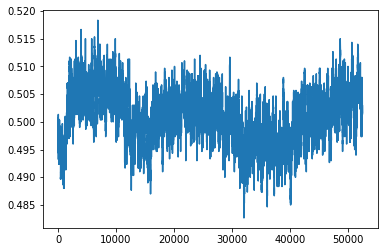

In [24]:
%matplotlib inline
plt.plot(np.arange(len(accuvs[:-1000])),accuvs[:-1000])

In [27]:
!mkdir checkpoints/SMSDatasetB1NES128/PEPS_16x9_Z2_Binary_TAT_19_v2

In [29]:
state_dict={}
state_dict['state_dict'] = model.state_dict()
state_dict['optimizer_TYPE']='Adam'
state_dict['optimizer_lr']  =0.001
state_dict['batch_size']    =200
state_dict['loss_fn']       ='BCEWithLogitsLoss'
state_dict['losses']    =losses
state_dict['accuts']    =accuts
state_dict['accuvs']    =accuvs
state_dict['script']    ='''
from models.extend_model import *
model =  PEPS_16x9_Z2_Binary_Aggregation_Wrapper(TensorAttention,
                                    "models/arbitary_shape/patch_partions_3column_12units.pt", alpha_list = 0.2,fixed_virtual_dim=2)(out_features=1)
'''
#torch.save(state_dict,"checkpoints/SMSDatasetB1NES128/PEPS_16x9_Z2_Binary_TAT_19_v2/overfitting_model_20220519.pt")

In [22]:
data_loader = test_loader
device = 'cuda'
model  = model.to(device).eval()
model.eval()
prefetcher = DataSimfetcher(data_loader, device=device)
inter_b    = logsys.create_progress_bar(len(data_loader))
labels     = []
logits     = []
with torch.no_grad():
    while inter_b.update_step():
        #image,label,_=  prefetcher.next()
        label,image = prefetcher.next()[:2]
        binary     = preprocess_images(image)
        logit      = model(binary).squeeze()
        #loss       = loss_fn(logit ,label.squeeze())
        labels.append(label)
        logits.append(logit)
labels  = torch.cat(labels)
logits  = torch.cat(logits)
if len(logits.shape)==2:
    pred_labels  = torch.argmax(logits,-1)
    accu =  torch.sum(pred_labels == labels)/len(pred_labels)
elif len(logits.shape)==1:
    accu =  torch.sum(torch.round(torch.sigmoid(logits)) == labels)/len(labels)
else:raise NotImplementedError
#accu = loss
#accues.append(accu)
#master_bar.update_graph_multiply([[losses[-100:],g_norm,accues[-100:]]])
accu = accu.item()
master_bar.lwrite('Epoch: %.3i \t Loss: %.4f \t Acct: %.4f \t Accu: %.4f \t Time: %.2f s' %(epoch, loss, accut,accu,time.time() - start_time),end='\r')

In [107]:
def sample(self, bs, random_start=False):
    """
    Sample images/spin configurations
    """

    device = self.tensors.device
    samples = torch.empty([bs, self.n], device=device)

    # if random_start = True, force s_1 = -1/+1 randomly
    if random_start:
        samples[:, 0] = torch.randint(2, size=(bs, ), dtype=torch.float, device=device)
    else:
        samples[:, 0] = 0.

    for idx in range(self.n - 1):
        if idx == 0:
            # sample s_2 from p(s_2 | s_1)
            embedded_data = torch.stack([samples[:, 0], 1.0 - samples[:, 0]], dim=1)  # (bs, 2)
            mats          = torch.einsum('lri,bi->blr', self.tensors[0, :, :, :] , embedded_data)
            left_vec      = mats[:, 0, :].unsqueeze(1)  # (bs, 1, D)
            logits        = torch.einsum('blr, ri->bli', left_vec,(self.tensors[1, :, :, :] )[:, 0, :]).squeeze(1)
            samples[:, 1] = torch.bernoulli(torch.softmax(logits, dim=1)[:, 0])
        else:
            # then sample s_3 from  p(s_3 | s_1, s_2) and so on
            embedded_data = torch.stack([samples[:, idx], 1.0 - samples[:, idx]], dim=1)  # (bs, 2)
            mats = torch.einsum('lri,bi->blr', self.tensors[idx, :, :, :] , embedded_data)
            left_vec = torch.bmm(left_vec, mats)  # (bs, 1, D)
            logits = torch.einsum('blr, ri->bli', left_vec,
                                  (self.tensors[idx + 1, :, :, :] )[:, 0, :]).squeeze(1)
            samples[:, idx + 1] = torch.bernoulli(torch.softmax(logits, dim=1)[:, 0])
    return samples